In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

# Import the libraries

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization, Bidirectional, LSTM, concatenate, Flatten
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [3]:
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [4]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [5]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [6]:
def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.9)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [7]:
def mean_squared_error(X, lenght = 5):
    squared_error = 0
    for i in range(0, X.shape[0] - lenght):
        x = X[i:i+lenght]
        mean = x.mean()
        std = x.std()
        x = (x - mean)/std
        y = (X[i+lenght] - mean)/std
        squared_error += np.square(x[-1]-y)
    return squared_error/X.shape[0]

In [8]:
# For generated data
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [9]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

## Generator

In [11]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    
    # Define the first Densely Connected Bidirectional LSTM layer
    lstm_1 = Bidirectional(LSTM(units=10, return_sequences=True, activation=None, kernel_initializer='random_normal', dropout=0.3))(inputs)
    lstm_1_batch_norm = BatchNormalization()(lstm_1)
    lstm_1_LRelu = LeakyReLU(alpha=0.3)(lstm_1_batch_norm)
    lstm_1_dropout = Dropout(0.3)(lstm_1_LRelu)
    
    # Define the second Densely Connected Bidirectional LSTM layer
    lstm_2_input = concatenate([lstm_1, inputs], axis=2)
    lstm_2 = Bidirectional(LSTM(units=10, return_sequences=False, activation=None, kernel_initializer='random_normal', dropout=0.3))(lstm_2_input)
    lstm_2_batch_norm = BatchNormalization()(lstm_2)
    lstm_2_LRelu = LeakyReLU(alpha=0.3)(lstm_2_batch_norm)
    lstm_2_dropout = Dropout(0.3)(lstm_2_LRelu)
    
    # Define the output layer
    output_dense = Dense(n_features, activation=None)(lstm_2_dropout)
    output = LeakyReLU(alpha=0.3)(output_dense)
    
    # Define the model
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()
    
    return model

## Discriminator

In [12]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [13]:
def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)

        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [14]:
def train(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
#         if(cur_gen_loss > 0.85):
#                 break;
    return history, history_val

## Visualization

In [15]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [16]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [17]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [18]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [19]:
stock_code = "AAPL"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2000-01-10    0.910714    0.912946    0.845982    0.872768    0.742829   
6    2000-01-11    0.856585    0.887277    0.808036    0.828125    0.704832   
7    2000-01-12    0.848214    0.852679    0.772321    0.778460    0.662561   
8    2000-01-13    0.843610    0.881696    0.825893    0.863839    0.735229   
9    2000-01-14    0.892857    0.912946    0.887277    0.896763    0.763251   
...         ...         ...         ...         ...         ...         ...   
5278 2020-12-23  132.160004  132.429993  130.779999  130.960007  129.209290   
5279 2020-12-24  131.320007  133.460007  131.100006  131.970001  130.205765   
5280 2020-12-28  133.990005  137.339996  133.509995  136.690002  134.862671   
5281 2020-12-29  138.050003  138.789993  134.339996  134.869995  133.067017   
5282 2020-12-30  135.580002  135.990005  133.399994  133.720001  131.932373   

          Volume          Ma  
5      505064000    0.915960  
6      441548800    0.890625  
7      976068800    0.873214  
8     1032684800    0.843192  
9      390376000    0.846317  
...          ...         ...  
5278    88223700  128.656000  
5279    54930100  129.286002  
5280   124486200  129.940002  
5281   121047300  131.946002  
5282    96452100  133.274002  

[5278 rows x 8 columns]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 5, 20)        1440        ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 5, 27)        0           ['bidirectional[0][0]',          
                                                                  'input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 20)          3040        ['concatenate[0][0]']        

Time for epoch 48 is 0.9293849468231201 sec Generator Loss: 0.8097449541091919,  Discriminator_loss: 1.348109483718872
Time for epoch 49 is 0.930124044418335 sec Generator Loss: 0.8115081191062927,  Discriminator_loss: 1.3382664918899536
Time for epoch 50 is 0.9249591827392578 sec Generator Loss: 0.822754442691803,  Discriminator_loss: 1.3344062566757202
Time for epoch 51 is 0.9651379585266113 sec Generator Loss: 0.8315907716751099,  Discriminator_loss: 1.3300461769104004
Time for epoch 52 is 0.9958620071411133 sec Generator Loss: 0.8238864541053772,  Discriminator_loss: 1.332825779914856
Time for epoch 53 is 0.9370319843292236 sec Generator Loss: 0.8164779543876648,  Discriminator_loss: 1.3375415802001953
Time for epoch 54 is 0.9352104663848877 sec Generator Loss: 0.8192286491394043,  Discriminator_loss: 1.3295280933380127
Time for epoch 55 is 0.979163408279419 sec Generator Loss: 0.8183654546737671,  Discriminator_loss: 1.3317136764526367
Time for epoch 56 is 0.9516909122467041 sec G

Time for epoch 117 is 0.9078030586242676 sec Generator Loss: 0.8093742728233337,  Discriminator_loss: 1.3447061777114868
Time for epoch 118 is 0.896681547164917 sec Generator Loss: 0.8169788718223572,  Discriminator_loss: 1.3417606353759766
Time for epoch 119 is 0.9173445701599121 sec Generator Loss: 0.8162082433700562,  Discriminator_loss: 1.3354514837265015
Time for epoch 120 is 0.8937966823577881 sec Generator Loss: 0.8108554482460022,  Discriminator_loss: 1.3346211910247803
Time for epoch 121 is 0.8961026668548584 sec Generator Loss: 0.8078454732894897,  Discriminator_loss: 1.3392952680587769
Time for epoch 122 is 0.8793585300445557 sec Generator Loss: 0.8027530908584595,  Discriminator_loss: 1.342160701751709
Time for epoch 123 is 0.8738317489624023 sec Generator Loss: 0.8019418120384216,  Discriminator_loss: 1.3403297662734985
Time for epoch 124 is 0.8823187351226807 sec Generator Loss: 0.8156546354293823,  Discriminator_loss: 1.3335899114608765
Time for epoch 125 is 0.8749797344

Time for epoch 186 is 0.9357051849365234 sec Generator Loss: 0.8150773644447327,  Discriminator_loss: 1.3340293169021606
Time for epoch 187 is 0.9081828594207764 sec Generator Loss: 0.8155438899993896,  Discriminator_loss: 1.3377505540847778
Time for epoch 188 is 0.8950333595275879 sec Generator Loss: 0.8176512718200684,  Discriminator_loss: 1.3323323726654053
Time for epoch 189 is 0.878781795501709 sec Generator Loss: 0.813310980796814,  Discriminator_loss: 1.3311424255371094
Time for epoch 190 is 0.8933086395263672 sec Generator Loss: 0.8103127479553223,  Discriminator_loss: 1.3326432704925537
Time for epoch 191 is 0.8827261924743652 sec Generator Loss: 0.8253681659698486,  Discriminator_loss: 1.332686424255371
Time for epoch 192 is 0.8750648498535156 sec Generator Loss: 0.8197617530822754,  Discriminator_loss: 1.3379441499710083
Time for epoch 193 is 0.8780062198638916 sec Generator Loss: 0.8271126747131348,  Discriminator_loss: 1.325870156288147
Time for epoch 194 is 0.892487287521

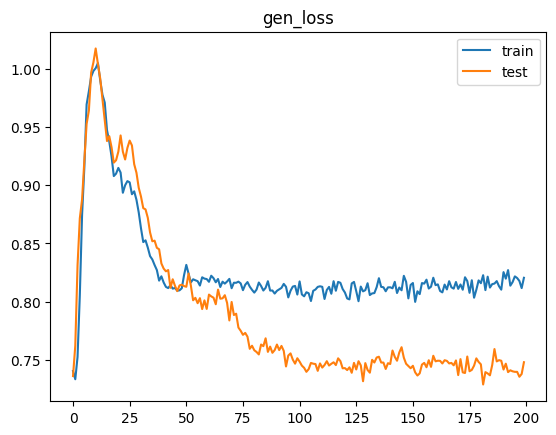

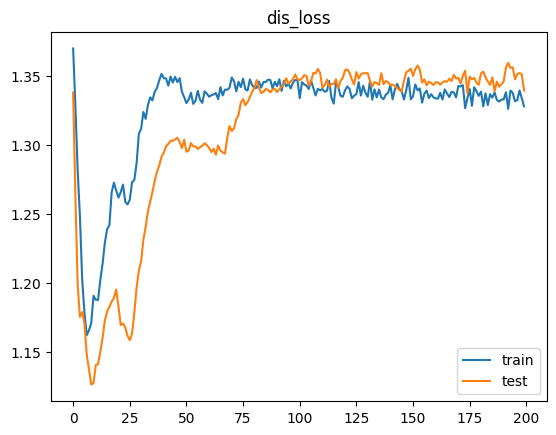

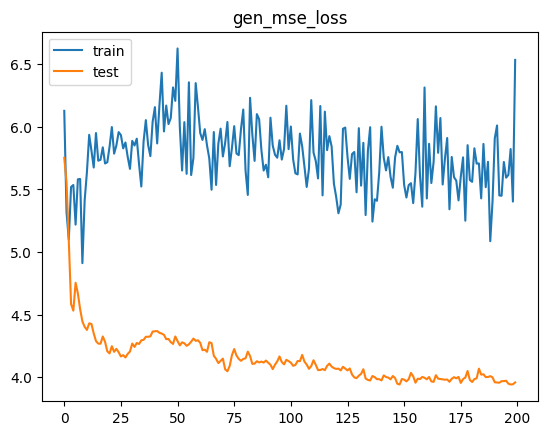

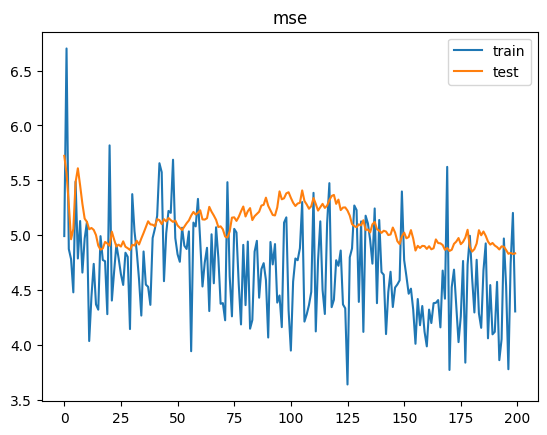

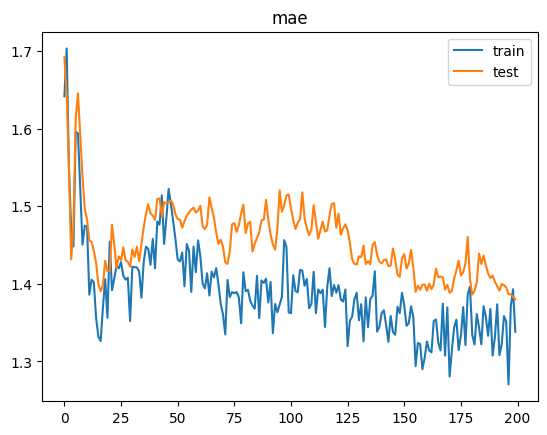

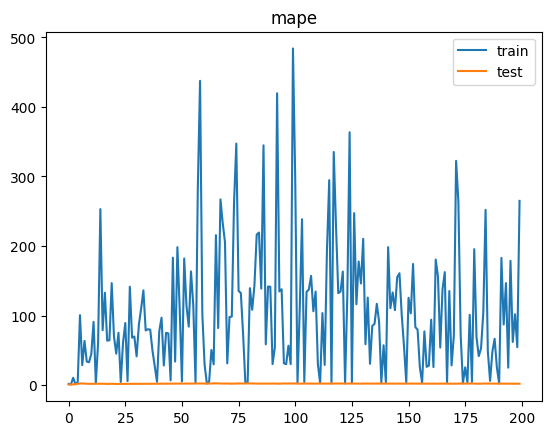

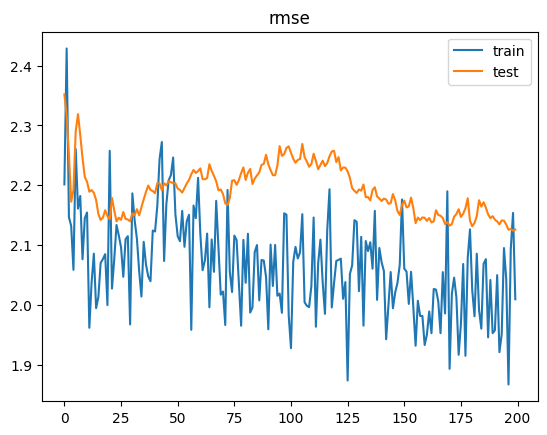

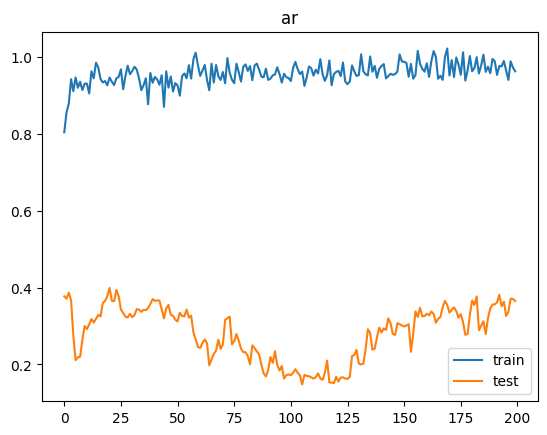

2/2 [==============================] - 1s 3ms/step


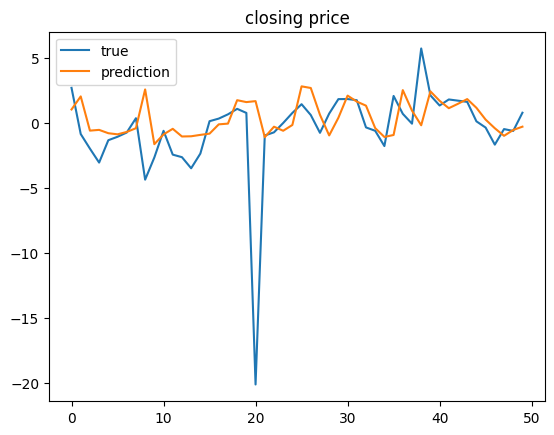

[MSE Baseline] train: 4.338214011580211  test: 4.679867713895856
Delta time with epochs = 200: 0:03:29.482781
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 5, 20)       1440        ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 5, 27)        0           ['bidirectional_2[0][0]',        
                                                                  'input_2[0][0]'

Time for epoch 46 is 1.0675747394561768 sec Generator Loss: 0.8089091181755066,  Discriminator_loss: 1.344758152961731
Time for epoch 47 is 1.001516580581665 sec Generator Loss: 0.806381344795227,  Discriminator_loss: 1.3434836864471436
Time for epoch 48 is 1.0386004447937012 sec Generator Loss: 0.8086091876029968,  Discriminator_loss: 1.3400828838348389
Time for epoch 49 is 1.027777910232544 sec Generator Loss: 0.8005976676940918,  Discriminator_loss: 1.3470301628112793
Time for epoch 50 is 1.045546293258667 sec Generator Loss: 0.7925609946250916,  Discriminator_loss: 1.3548212051391602
Time for epoch 51 is 1.0001416206359863 sec Generator Loss: 0.7976944446563721,  Discriminator_loss: 1.3512167930603027
Time for epoch 52 is 0.978722333908081 sec Generator Loss: 0.7990564107894897,  Discriminator_loss: 1.3575342893600464
Time for epoch 53 is 1.006237506866455 sec Generator Loss: 0.7875145673751831,  Discriminator_loss: 1.3608192205429077
Time for epoch 54 is 1.0579702854156494 sec Gen

Time for epoch 115 is 0.9420866966247559 sec Generator Loss: 0.7926891446113586,  Discriminator_loss: 1.351454257965088
Time for epoch 116 is 0.9143407344818115 sec Generator Loss: 0.7984778881072998,  Discriminator_loss: 1.3519991636276245
Time for epoch 117 is 0.8958537578582764 sec Generator Loss: 0.798844039440155,  Discriminator_loss: 1.3491790294647217
Time for epoch 118 is 0.8943445682525635 sec Generator Loss: 0.7970382571220398,  Discriminator_loss: 1.3556996583938599
Time for epoch 119 is 0.9117932319641113 sec Generator Loss: 0.789078414440155,  Discriminator_loss: 1.3525763750076294
Time for epoch 120 is 0.9406273365020752 sec Generator Loss: 0.7931784987449646,  Discriminator_loss: 1.3497449159622192
Time for epoch 121 is 0.908437967300415 sec Generator Loss: 0.7879868745803833,  Discriminator_loss: 1.3586982488632202
Time for epoch 122 is 0.9148635864257812 sec Generator Loss: 0.7885878682136536,  Discriminator_loss: 1.3527112007141113
Time for epoch 123 is 0.918429851531

Time for epoch 184 is 0.9234161376953125 sec Generator Loss: 0.7880834341049194,  Discriminator_loss: 1.3530975580215454
Time for epoch 185 is 0.8907129764556885 sec Generator Loss: 0.7938963770866394,  Discriminator_loss: 1.3488049507141113
Time for epoch 186 is 0.9236001968383789 sec Generator Loss: 0.7883308529853821,  Discriminator_loss: 1.3547704219818115
Time for epoch 187 is 0.9245390892028809 sec Generator Loss: 0.7926020622253418,  Discriminator_loss: 1.3494291305541992
Time for epoch 188 is 0.9506762027740479 sec Generator Loss: 0.7841051816940308,  Discriminator_loss: 1.3532545566558838
Time for epoch 189 is 0.933466911315918 sec Generator Loss: 0.784295380115509,  Discriminator_loss: 1.3564879894256592
Time for epoch 190 is 0.9648430347442627 sec Generator Loss: 0.7928176522254944,  Discriminator_loss: 1.3503376245498657
Time for epoch 191 is 1.0230364799499512 sec Generator Loss: 0.788309633731842,  Discriminator_loss: 1.3569586277008057
Time for epoch 192 is 1.11183667182

Time for epoch 252 is 0.9878852367401123 sec Generator Loss: 0.7935899496078491,  Discriminator_loss: 1.3473703861236572
Time for epoch 253 is 1.0122873783111572 sec Generator Loss: 0.7986893653869629,  Discriminator_loss: 1.3468741178512573
Time for epoch 254 is 0.9778275489807129 sec Generator Loss: 0.7939355969429016,  Discriminator_loss: 1.3504222631454468
Time for epoch 255 is 1.1105096340179443 sec Generator Loss: 0.798761248588562,  Discriminator_loss: 1.34970223903656
Time for epoch 256 is 0.9754869937896729 sec Generator Loss: 0.7952222228050232,  Discriminator_loss: 1.345719814300537
Time for epoch 257 is 1.0135071277618408 sec Generator Loss: 0.7929649353027344,  Discriminator_loss: 1.3516974449157715
Time for epoch 258 is 0.9833717346191406 sec Generator Loss: 0.7924332618713379,  Discriminator_loss: 1.3500659465789795
Time for epoch 259 is 0.9945745468139648 sec Generator Loss: 0.8090401887893677,  Discriminator_loss: 1.3403691053390503
Time for epoch 260 is 0.896936178207

Time for epoch 321 is 1.0138931274414062 sec Generator Loss: 0.8161509037017822,  Discriminator_loss: 1.3374207019805908
Time for epoch 322 is 1.0529189109802246 sec Generator Loss: 0.8095110654830933,  Discriminator_loss: 1.3403393030166626
Time for epoch 323 is 0.9482169151306152 sec Generator Loss: 0.8017382621765137,  Discriminator_loss: 1.344496488571167
Time for epoch 324 is 0.9383835792541504 sec Generator Loss: 0.8074049949645996,  Discriminator_loss: 1.339491844177246
Time for epoch 325 is 0.8869099617004395 sec Generator Loss: 0.8056391477584839,  Discriminator_loss: 1.3364338874816895
Time for epoch 326 is 0.8897013664245605 sec Generator Loss: 0.8081890344619751,  Discriminator_loss: 1.337388038635254
Time for epoch 327 is 0.9015986919403076 sec Generator Loss: 0.8130105137825012,  Discriminator_loss: 1.3307877779006958
Time for epoch 328 is 0.8920292854309082 sec Generator Loss: 0.8107508420944214,  Discriminator_loss: 1.3334389925003052
Time for epoch 329 is 0.89231252670

Time for epoch 389 is 0.921353816986084 sec Generator Loss: 0.8127321600914001,  Discriminator_loss: 1.3316056728363037
Time for epoch 390 is 1.0117509365081787 sec Generator Loss: 0.8283227682113647,  Discriminator_loss: 1.326797366142273
Time for epoch 391 is 0.9841692447662354 sec Generator Loss: 0.8313027620315552,  Discriminator_loss: 1.3253697156906128
Time for epoch 392 is 1.0020203590393066 sec Generator Loss: 0.8206183314323425,  Discriminator_loss: 1.3376960754394531
Time for epoch 393 is 0.9287106990814209 sec Generator Loss: 0.8285694718360901,  Discriminator_loss: 1.3257228136062622
Time for epoch 394 is 0.9432833194732666 sec Generator Loss: 0.8210315108299255,  Discriminator_loss: 1.3309580087661743
Time for epoch 395 is 0.8931975364685059 sec Generator Loss: 0.8240659236907959,  Discriminator_loss: 1.3262927532196045
Time for epoch 396 is 0.8843257427215576 sec Generator Loss: 0.8081110119819641,  Discriminator_loss: 1.3412002325057983
Time for epoch 397 is 0.8814787864

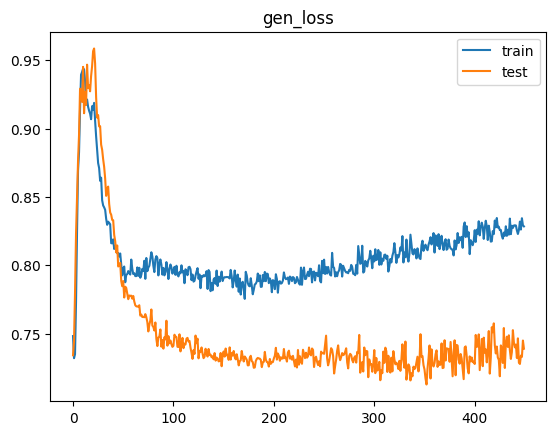

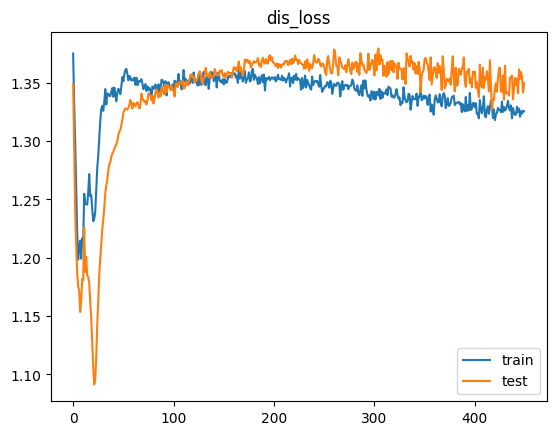

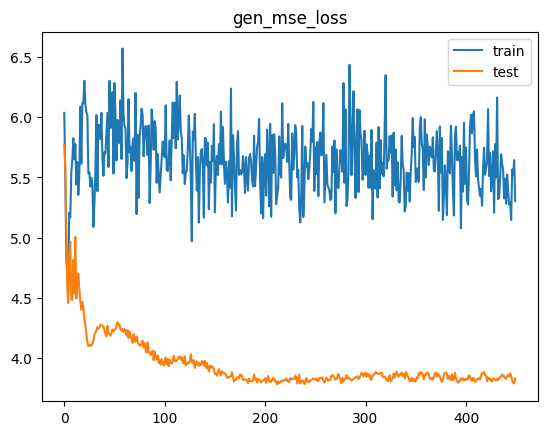

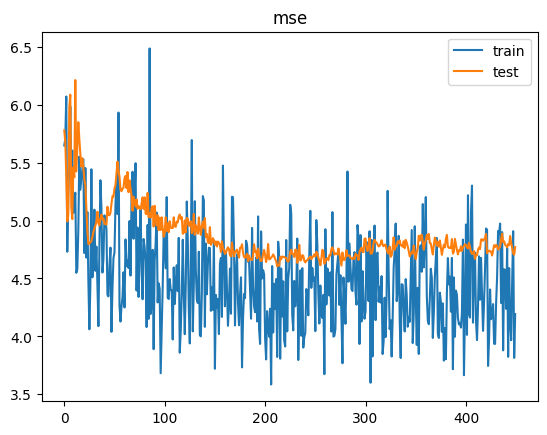

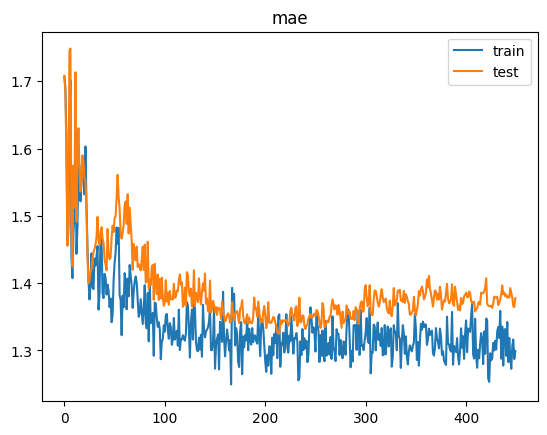

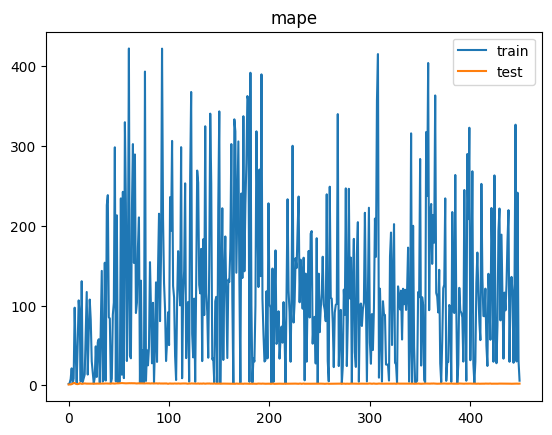

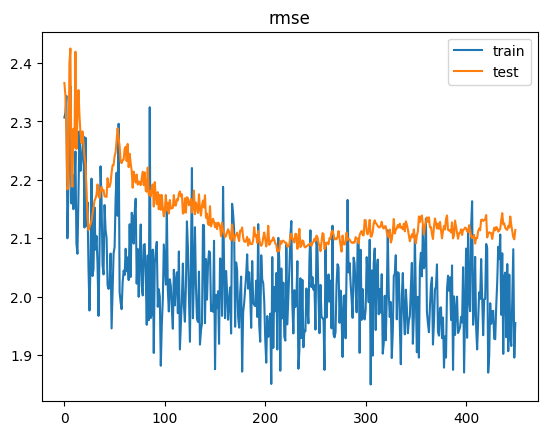

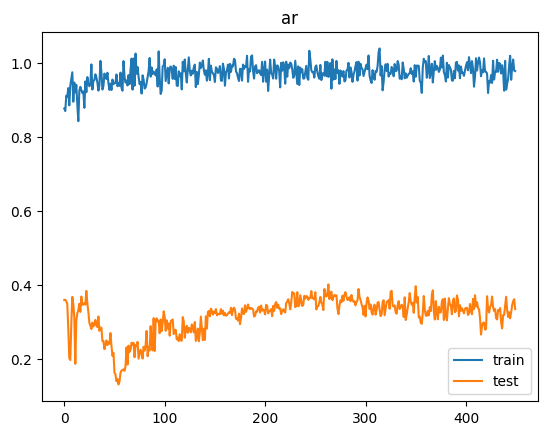

2/2 [==============================] - 1s 3ms/step


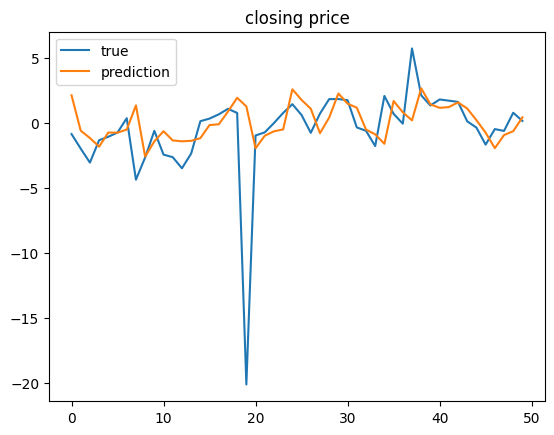

[MSE Baseline] train: 3.8169591872422943  test: 4.6881765064049805
Delta time with epochs = 450: 0:07:31.825420
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 5, 20)       1440        ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 5, 27)        0           ['bidirectional_4[0][0]',        
                                                                  'input_3[0][0

Time for epoch 46 is 0.9280490875244141 sec Generator Loss: 0.8071717619895935,  Discriminator_loss: 1.3447484970092773
Time for epoch 47 is 0.9736161231994629 sec Generator Loss: 0.8130707144737244,  Discriminator_loss: 1.3330518007278442
Time for epoch 48 is 0.924954891204834 sec Generator Loss: 0.8097754120826721,  Discriminator_loss: 1.335228443145752
Time for epoch 49 is 0.9288716316223145 sec Generator Loss: 0.8102487921714783,  Discriminator_loss: 1.3440275192260742
Time for epoch 50 is 0.9154882431030273 sec Generator Loss: 0.8150219321250916,  Discriminator_loss: 1.344565510749817
Time for epoch 51 is 0.9277293682098389 sec Generator Loss: 0.8038049340248108,  Discriminator_loss: 1.3486765623092651
Time for epoch 52 is 0.9415426254272461 sec Generator Loss: 0.8031438589096069,  Discriminator_loss: 1.350182294845581
Time for epoch 53 is 0.9292232990264893 sec Generator Loss: 0.8060909509658813,  Discriminator_loss: 1.3467832803726196
Time for epoch 54 is 0.9270117282867432 sec 

Time for epoch 115 is 0.898658275604248 sec Generator Loss: 0.8070250749588013,  Discriminator_loss: 1.3426908254623413
Time for epoch 116 is 0.9372458457946777 sec Generator Loss: 0.7918897867202759,  Discriminator_loss: 1.3488231897354126
Time for epoch 117 is 0.8965330123901367 sec Generator Loss: 0.7939590215682983,  Discriminator_loss: 1.351343035697937
Time for epoch 118 is 0.8883492946624756 sec Generator Loss: 0.7973600029945374,  Discriminator_loss: 1.3455705642700195
Time for epoch 119 is 0.8925683498382568 sec Generator Loss: 0.7905452251434326,  Discriminator_loss: 1.3521496057510376
Time for epoch 120 is 0.8376975059509277 sec Generator Loss: 0.79839688539505,  Discriminator_loss: 1.3482424020767212
Time for epoch 121 is 0.997246503829956 sec Generator Loss: 0.7968214154243469,  Discriminator_loss: 1.3512123823165894
Time for epoch 122 is 1.0681886672973633 sec Generator Loss: 0.7932066917419434,  Discriminator_loss: 1.3486829996109009
Time for epoch 123 is 0.9058961868286

Time for epoch 183 is 0.9436755180358887 sec Generator Loss: 0.8048484325408936,  Discriminator_loss: 1.349958896636963
Time for epoch 184 is 0.8982312679290771 sec Generator Loss: 0.8012970089912415,  Discriminator_loss: 1.3503180742263794
Time for epoch 185 is 0.8997628688812256 sec Generator Loss: 0.7902107238769531,  Discriminator_loss: 1.3513197898864746
Time for epoch 186 is 0.8965351581573486 sec Generator Loss: 0.7909240126609802,  Discriminator_loss: 1.36004638671875
Time for epoch 187 is 0.9935853481292725 sec Generator Loss: 0.7936369180679321,  Discriminator_loss: 1.351507544517517
Time for epoch 188 is 0.9472377300262451 sec Generator Loss: 0.7902494668960571,  Discriminator_loss: 1.3594197034835815
Time for epoch 189 is 0.9802248477935791 sec Generator Loss: 0.7924110889434814,  Discriminator_loss: 1.353496789932251
Time for epoch 190 is 0.9211359024047852 sec Generator Loss: 0.7919337749481201,  Discriminator_loss: 1.3607277870178223
Time for epoch 191 is 0.9101338386535

Time for epoch 251 is 0.8469445705413818 sec Generator Loss: 0.7948094010353088,  Discriminator_loss: 1.3488895893096924
Time for epoch 252 is 0.8338925838470459 sec Generator Loss: 0.7962777614593506,  Discriminator_loss: 1.3535504341125488
Time for epoch 253 is 0.8511853218078613 sec Generator Loss: 0.794506847858429,  Discriminator_loss: 1.3549078702926636
Time for epoch 254 is 0.8541584014892578 sec Generator Loss: 0.792071521282196,  Discriminator_loss: 1.3519423007965088
Time for epoch 255 is 0.8384504318237305 sec Generator Loss: 0.797677218914032,  Discriminator_loss: 1.347116470336914
Time for epoch 256 is 0.8560853004455566 sec Generator Loss: 0.7920358777046204,  Discriminator_loss: 1.3458207845687866
Time for epoch 257 is 0.8757481575012207 sec Generator Loss: 0.7931526899337769,  Discriminator_loss: 1.3511430025100708
Time for epoch 258 is 0.8786718845367432 sec Generator Loss: 0.7948010563850403,  Discriminator_loss: 1.3437315225601196
Time for epoch 259 is 0.935136079788

Time for epoch 319 is 0.896369457244873 sec Generator Loss: 0.8155046701431274,  Discriminator_loss: 1.3355964422225952
Time for epoch 320 is 0.8947031497955322 sec Generator Loss: 0.8176442384719849,  Discriminator_loss: 1.3333404064178467
Time for epoch 321 is 0.8930916786193848 sec Generator Loss: 0.8114452958106995,  Discriminator_loss: 1.3408751487731934
Time for epoch 322 is 0.9683289527893066 sec Generator Loss: 0.8042343258857727,  Discriminator_loss: 1.3419233560562134
Time for epoch 323 is 0.9514756202697754 sec Generator Loss: 0.8144481182098389,  Discriminator_loss: 1.3334919214248657
Time for epoch 324 is 0.9409995079040527 sec Generator Loss: 0.8098762631416321,  Discriminator_loss: 1.3353116512298584
Time for epoch 325 is 0.9581780433654785 sec Generator Loss: 0.8155272603034973,  Discriminator_loss: 1.333603024482727
Time for epoch 326 is 0.9000453948974609 sec Generator Loss: 0.8141958713531494,  Discriminator_loss: 1.3374706506729126
Time for epoch 327 is 0.9309840202

Time for epoch 388 is 0.9977302551269531 sec Generator Loss: 0.8238847851753235,  Discriminator_loss: 1.3288514614105225
Time for epoch 389 is 0.9600915908813477 sec Generator Loss: 0.8207916021347046,  Discriminator_loss: 1.3273403644561768
Time for epoch 390 is 0.9807934761047363 sec Generator Loss: 0.8293134570121765,  Discriminator_loss: 1.3266124725341797
Time for epoch 391 is 0.9540853500366211 sec Generator Loss: 0.8242427706718445,  Discriminator_loss: 1.3266727924346924
Time for epoch 392 is 1.0073657035827637 sec Generator Loss: 0.8309429287910461,  Discriminator_loss: 1.3248628377914429
Time for epoch 393 is 0.9961838722229004 sec Generator Loss: 0.8171260952949524,  Discriminator_loss: 1.3282666206359863
Time for epoch 394 is 1.0093648433685303 sec Generator Loss: 0.8202984929084778,  Discriminator_loss: 1.3296613693237305
Time for epoch 395 is 0.9696080684661865 sec Generator Loss: 0.8268736004829407,  Discriminator_loss: 1.325371503829956
Time for epoch 396 is 0.995137691

Time for epoch 456 is 0.905529260635376 sec Generator Loss: 0.8316836953163147,  Discriminator_loss: 1.3322029113769531
Time for epoch 457 is 0.9128766059875488 sec Generator Loss: 0.8290793299674988,  Discriminator_loss: 1.323615550994873
Time for epoch 458 is 0.951885461807251 sec Generator Loss: 0.8343482613563538,  Discriminator_loss: 1.3246996402740479
Time for epoch 459 is 0.9945292472839355 sec Generator Loss: 0.8351922035217285,  Discriminator_loss: 1.3276811838150024
Time for epoch 460 is 1.024456262588501 sec Generator Loss: 0.8364410400390625,  Discriminator_loss: 1.3250433206558228
Time for epoch 461 is 1.0423145294189453 sec Generator Loss: 0.8210576176643372,  Discriminator_loss: 1.3334707021713257
Time for epoch 462 is 0.9288311004638672 sec Generator Loss: 0.8247852921485901,  Discriminator_loss: 1.323862075805664
Time for epoch 463 is 0.983102560043335 sec Generator Loss: 0.8238561749458313,  Discriminator_loss: 1.330087423324585
Time for epoch 464 is 1.042705774307251

Time for epoch 524 is 0.9039130210876465 sec Generator Loss: 0.8266059160232544,  Discriminator_loss: 1.3249989748001099
Time for epoch 525 is 0.9012649059295654 sec Generator Loss: 0.8407084941864014,  Discriminator_loss: 1.3157958984375
Time for epoch 526 is 0.9113450050354004 sec Generator Loss: 0.8392332792282104,  Discriminator_loss: 1.32550048828125
Time for epoch 527 is 0.9026257991790771 sec Generator Loss: 0.8396574258804321,  Discriminator_loss: 1.3176493644714355
Time for epoch 528 is 0.9123656749725342 sec Generator Loss: 0.8379886746406555,  Discriminator_loss: 1.3293273448944092
Time for epoch 529 is 0.9044396877288818 sec Generator Loss: 0.8421176075935364,  Discriminator_loss: 1.3232065439224243
Time for epoch 530 is 0.9012105464935303 sec Generator Loss: 0.8395158052444458,  Discriminator_loss: 1.313858985900879
Time for epoch 531 is 0.9009799957275391 sec Generator Loss: 0.8339228630065918,  Discriminator_loss: 1.3253756761550903
Time for epoch 532 is 0.90118360519409

Time for epoch 593 is 0.9294734001159668 sec Generator Loss: 0.8408961296081543,  Discriminator_loss: 1.3179413080215454
Time for epoch 594 is 0.9260735511779785 sec Generator Loss: 0.8421320915222168,  Discriminator_loss: 1.3160067796707153
Time for epoch 595 is 0.9556622505187988 sec Generator Loss: 0.840541422367096,  Discriminator_loss: 1.317934274673462
Time for epoch 596 is 0.9159808158874512 sec Generator Loss: 0.844249427318573,  Discriminator_loss: 1.3213411569595337
Time for epoch 597 is 0.9092118740081787 sec Generator Loss: 0.8520905375480652,  Discriminator_loss: 1.3183002471923828
Time for epoch 598 is 0.9341084957122803 sec Generator Loss: 0.8450108170509338,  Discriminator_loss: 1.3145301342010498
Time for epoch 599 is 0.9241130352020264 sec Generator Loss: 0.8491531014442444,  Discriminator_loss: 1.3177382946014404
Time for epoch 600 is 0.9134044647216797 sec Generator Loss: 0.8415071368217468,  Discriminator_loss: 1.3179956674575806
Time for epoch 601 is 0.92740154266

Time for epoch 662 is 0.9693844318389893 sec Generator Loss: 0.8471837043762207,  Discriminator_loss: 1.3207142353057861
Time for epoch 663 is 0.9798934459686279 sec Generator Loss: 0.8501243591308594,  Discriminator_loss: 1.3146222829818726
Time for epoch 664 is 0.9709877967834473 sec Generator Loss: 0.8479069471359253,  Discriminator_loss: 1.3225706815719604
Time for epoch 665 is 1.2112653255462646 sec Generator Loss: 0.849086344242096,  Discriminator_loss: 1.3104726076126099
Time for epoch 666 is 1.1431241035461426 sec Generator Loss: 0.8455949425697327,  Discriminator_loss: 1.3111152648925781
Time for epoch 667 is 1.1613819599151611 sec Generator Loss: 0.8441241383552551,  Discriminator_loss: 1.3194652795791626
Time for epoch 668 is 1.0367851257324219 sec Generator Loss: 0.8389121294021606,  Discriminator_loss: 1.3227852582931519
Time for epoch 669 is 1.0136501789093018 sec Generator Loss: 0.8455345630645752,  Discriminator_loss: 1.3171720504760742
Time for epoch 670 is 1.059103727

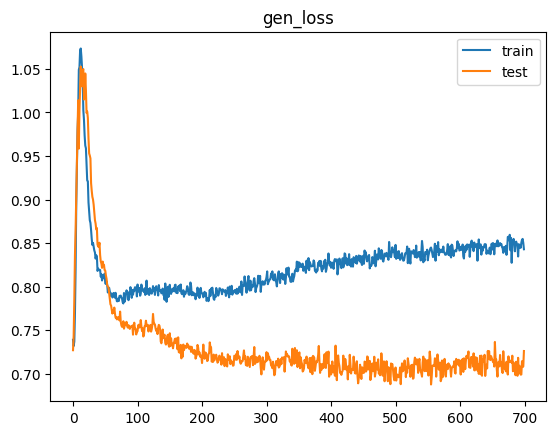

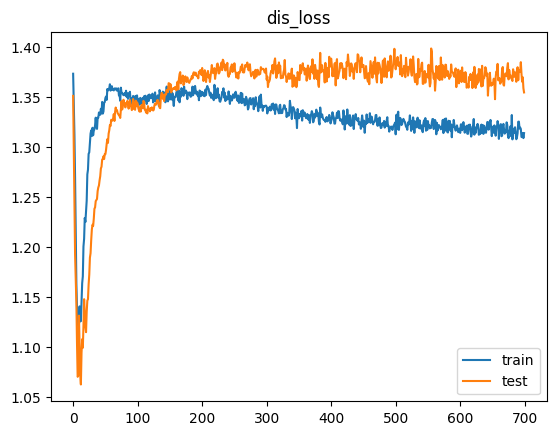

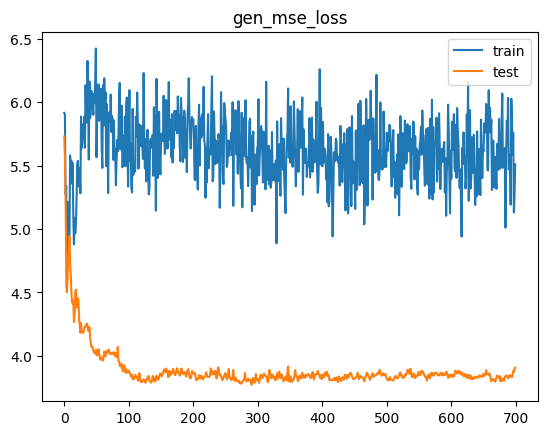

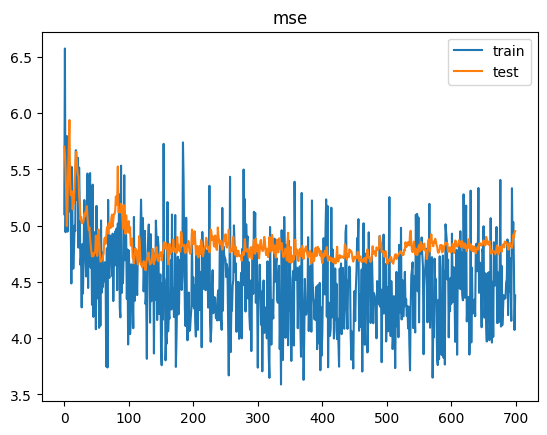

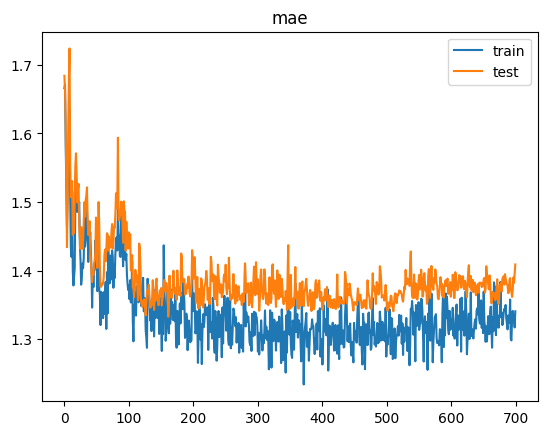

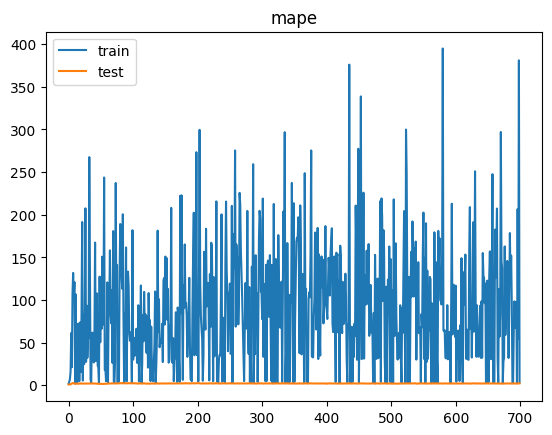

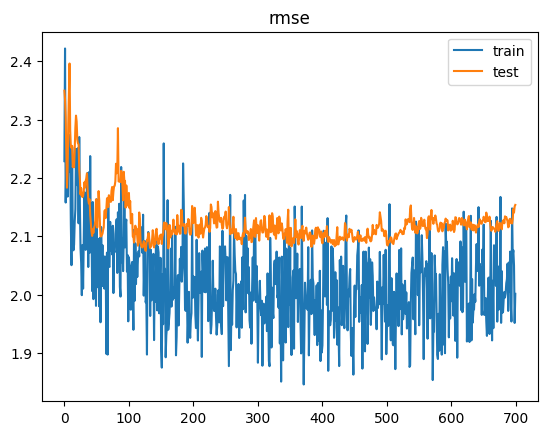

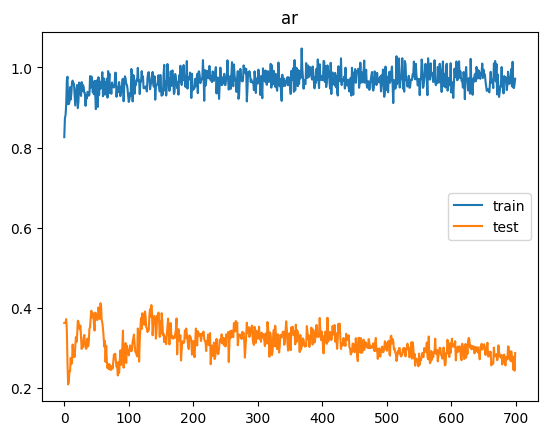

2/2 [==============================] - 1s 4ms/step


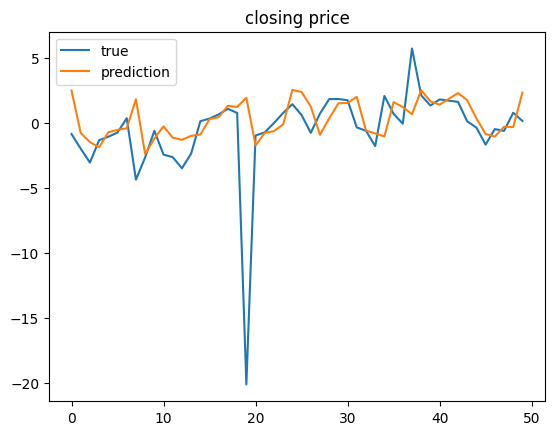

[MSE Baseline] train: 4.626520948389502  test: 4.6881765064049805
Delta time with epochs = 700: 0:11:24.192964
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 5, 20)       1440        ['input_4[0][0]']                
 )                                                                                                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 5, 27)        0           ['bidirectional_6[0][0]',        
                                                                  'input_4[0][0]

Time for epoch 46 is 1.004741907119751 sec Generator Loss: 0.8635919094085693,  Discriminator_loss: 1.3062043190002441
Time for epoch 47 is 0.9660460948944092 sec Generator Loss: 0.8668937087059021,  Discriminator_loss: 1.307605266571045
Time for epoch 48 is 0.999739408493042 sec Generator Loss: 0.8618832230567932,  Discriminator_loss: 1.3198437690734863
Time for epoch 49 is 0.9630310535430908 sec Generator Loss: 0.8657757639884949,  Discriminator_loss: 1.3166613578796387
Time for epoch 50 is 0.9629204273223877 sec Generator Loss: 0.863760769367218,  Discriminator_loss: 1.319753885269165
Time for epoch 51 is 1.0014853477478027 sec Generator Loss: 0.858191967010498,  Discriminator_loss: 1.3113632202148438
Time for epoch 52 is 0.9648406505584717 sec Generator Loss: 0.8575427532196045,  Discriminator_loss: 1.3304786682128906
Time for epoch 53 is 1.0341911315917969 sec Generator Loss: 0.8554388880729675,  Discriminator_loss: 1.3313275575637817
Time for epoch 54 is 0.9636344909667969 sec Ge

Time for epoch 115 is 0.91636061668396 sec Generator Loss: 0.8154757022857666,  Discriminator_loss: 1.3356338739395142
Time for epoch 116 is 0.9158380031585693 sec Generator Loss: 0.8114413619041443,  Discriminator_loss: 1.326312780380249
Time for epoch 117 is 0.9403972625732422 sec Generator Loss: 0.8124596476554871,  Discriminator_loss: 1.333998441696167
Time for epoch 118 is 0.9217464923858643 sec Generator Loss: 0.8044226169586182,  Discriminator_loss: 1.3322206735610962
Time for epoch 119 is 0.9125256538391113 sec Generator Loss: 0.8172662854194641,  Discriminator_loss: 1.3286890983581543
Time for epoch 120 is 0.9018311500549316 sec Generator Loss: 0.819821834564209,  Discriminator_loss: 1.3246188163757324
Time for epoch 121 is 0.9463527202606201 sec Generator Loss: 0.8169957995414734,  Discriminator_loss: 1.3340108394622803
Time for epoch 122 is 0.9571175575256348 sec Generator Loss: 0.8179395198822021,  Discriminator_loss: 1.3253008127212524
Time for epoch 123 is 0.9135236740112

Time for epoch 184 is 0.9267275333404541 sec Generator Loss: 0.8076189160346985,  Discriminator_loss: 1.3372255563735962
Time for epoch 185 is 0.9311251640319824 sec Generator Loss: 0.8143315315246582,  Discriminator_loss: 1.3340696096420288
Time for epoch 186 is 0.9067695140838623 sec Generator Loss: 0.8089841604232788,  Discriminator_loss: 1.343575358390808
Time for epoch 187 is 0.9001009464263916 sec Generator Loss: 0.8114908933639526,  Discriminator_loss: 1.335052251815796
Time for epoch 188 is 0.9081418514251709 sec Generator Loss: 0.8100566864013672,  Discriminator_loss: 1.3316400051116943
Time for epoch 189 is 0.9075894355773926 sec Generator Loss: 0.8148120045661926,  Discriminator_loss: 1.3359684944152832
Time for epoch 190 is 0.9153957366943359 sec Generator Loss: 0.8092831373214722,  Discriminator_loss: 1.3419314622879028
Time for epoch 191 is 0.9749855995178223 sec Generator Loss: 0.8172869086265564,  Discriminator_loss: 1.3356704711914062
Time for epoch 192 is 0.9222085475

Time for epoch 252 is 0.9081904888153076 sec Generator Loss: 0.8295574188232422,  Discriminator_loss: 1.320582628250122
Time for epoch 253 is 0.9104063510894775 sec Generator Loss: 0.8248916268348694,  Discriminator_loss: 1.3303453922271729
Time for epoch 254 is 0.937701940536499 sec Generator Loss: 0.8240593671798706,  Discriminator_loss: 1.3304640054702759
Time for epoch 255 is 0.9114184379577637 sec Generator Loss: 0.8272265791893005,  Discriminator_loss: 1.3319798707962036
Time for epoch 256 is 0.9170839786529541 sec Generator Loss: 0.8259783387184143,  Discriminator_loss: 1.3292622566223145
Time for epoch 257 is 0.937525749206543 sec Generator Loss: 0.8283188343048096,  Discriminator_loss: 1.329527497291565
Time for epoch 258 is 0.9046285152435303 sec Generator Loss: 0.8404613137245178,  Discriminator_loss: 1.3204280138015747
Time for epoch 259 is 0.9245510101318359 sec Generator Loss: 0.8245989680290222,  Discriminator_loss: 1.3323079347610474
Time for epoch 260 is 1.037880897521

Time for epoch 321 is 0.9361362457275391 sec Generator Loss: 0.8507808446884155,  Discriminator_loss: 1.314664602279663
Time for epoch 322 is 0.9231693744659424 sec Generator Loss: 0.8405206203460693,  Discriminator_loss: 1.3182997703552246
Time for epoch 323 is 0.9148719310760498 sec Generator Loss: 0.8459520936012268,  Discriminator_loss: 1.319600224494934
Time for epoch 324 is 0.910707950592041 sec Generator Loss: 0.8453553915023804,  Discriminator_loss: 1.3175461292266846
Time for epoch 325 is 0.9214396476745605 sec Generator Loss: 0.8411052227020264,  Discriminator_loss: 1.3198670148849487
Time for epoch 326 is 0.911210298538208 sec Generator Loss: 0.8348286151885986,  Discriminator_loss: 1.3218897581100464
Time for epoch 327 is 0.9381043910980225 sec Generator Loss: 0.8321169018745422,  Discriminator_loss: 1.3277968168258667
Time for epoch 328 is 0.9107675552368164 sec Generator Loss: 0.8363639712333679,  Discriminator_loss: 1.3252557516098022
Time for epoch 329 is 0.915494441986

Time for epoch 389 is 0.9357781410217285 sec Generator Loss: 0.8464241623878479,  Discriminator_loss: 1.3112517595291138
Time for epoch 390 is 0.9258782863616943 sec Generator Loss: 0.8375568389892578,  Discriminator_loss: 1.3167279958724976
Time for epoch 391 is 0.913001298904419 sec Generator Loss: 0.8446841239929199,  Discriminator_loss: 1.3191003799438477
Time for epoch 392 is 0.9534001350402832 sec Generator Loss: 0.8509650230407715,  Discriminator_loss: 1.3112893104553223
Time for epoch 393 is 0.905432939529419 sec Generator Loss: 0.849620521068573,  Discriminator_loss: 1.3185912370681763
Time for epoch 394 is 0.9512872695922852 sec Generator Loss: 0.8588259816169739,  Discriminator_loss: 1.3120994567871094
Time for epoch 395 is 1.103424072265625 sec Generator Loss: 0.8447041511535645,  Discriminator_loss: 1.3139349222183228
Time for epoch 396 is 1.0577335357666016 sec Generator Loss: 0.8534864783287048,  Discriminator_loss: 1.3171590566635132
Time for epoch 397 is 1.013310194015

Time for epoch 458 is 0.9872581958770752 sec Generator Loss: 0.8623648881912231,  Discriminator_loss: 1.3088773488998413
Time for epoch 459 is 1.0042011737823486 sec Generator Loss: 0.8535265326499939,  Discriminator_loss: 1.3155186176300049
Time for epoch 460 is 1.1196162700653076 sec Generator Loss: 0.862467885017395,  Discriminator_loss: 1.3130632638931274
Time for epoch 461 is 1.0766136646270752 sec Generator Loss: 0.8578347563743591,  Discriminator_loss: 1.3069968223571777
Time for epoch 462 is 1.2612426280975342 sec Generator Loss: 0.8443415760993958,  Discriminator_loss: 1.3214247226715088
Time for epoch 463 is 1.1915395259857178 sec Generator Loss: 0.8463542461395264,  Discriminator_loss: 1.3157461881637573
Time for epoch 464 is 0.9975378513336182 sec Generator Loss: 0.8490822315216064,  Discriminator_loss: 1.3074970245361328
Time for epoch 465 is 0.9558227062225342 sec Generator Loss: 0.8510506749153137,  Discriminator_loss: 1.3099697828292847
Time for epoch 466 is 1.017899513

Time for epoch 526 is 0.9614303112030029 sec Generator Loss: 0.8555951714515686,  Discriminator_loss: 1.307836890220642
Time for epoch 527 is 0.9593384265899658 sec Generator Loss: 0.8560599088668823,  Discriminator_loss: 1.3189895153045654
Time for epoch 528 is 0.9136662483215332 sec Generator Loss: 0.8547264933586121,  Discriminator_loss: 1.3052221536636353
Time for epoch 529 is 0.9592633247375488 sec Generator Loss: 0.854557991027832,  Discriminator_loss: 1.311142086982727
Time for epoch 530 is 0.9664721488952637 sec Generator Loss: 0.8597496747970581,  Discriminator_loss: 1.3047926425933838
Time for epoch 531 is 0.9664351940155029 sec Generator Loss: 0.8560467958450317,  Discriminator_loss: 1.3110296726226807
Time for epoch 532 is 0.9746122360229492 sec Generator Loss: 0.8625333905220032,  Discriminator_loss: 1.2960844039916992
Time for epoch 533 is 0.9216983318328857 sec Generator Loss: 0.862114667892456,  Discriminator_loss: 1.3045625686645508
Time for epoch 534 is 0.934210062026

Time for epoch 594 is 0.9338991641998291 sec Generator Loss: 0.8650785088539124,  Discriminator_loss: 1.3007261753082275
Time for epoch 595 is 1.2306511402130127 sec Generator Loss: 0.8525766134262085,  Discriminator_loss: 1.3053241968154907
Time for epoch 596 is 1.0673551559448242 sec Generator Loss: 0.869828999042511,  Discriminator_loss: 1.3071987628936768
Time for epoch 597 is 0.993945837020874 sec Generator Loss: 0.8576626181602478,  Discriminator_loss: 1.3041229248046875
Time for epoch 598 is 0.9760072231292725 sec Generator Loss: 0.867967963218689,  Discriminator_loss: 1.3019415140151978
Time for epoch 599 is 1.075340986251831 sec Generator Loss: 0.8627851009368896,  Discriminator_loss: 1.3124338388442993
Time for epoch 600 is 0.9449405670166016 sec Generator Loss: 0.8623950481414795,  Discriminator_loss: 1.304032325744629
Time for epoch 601 is 0.9565815925598145 sec Generator Loss: 0.8737471103668213,  Discriminator_loss: 1.313172459602356
Time for epoch 602 is 0.95110845565795

Time for epoch 662 is 0.9409682750701904 sec Generator Loss: 0.8764967322349548,  Discriminator_loss: 1.2898622751235962
Time for epoch 663 is 0.9604146480560303 sec Generator Loss: 0.8552190661430359,  Discriminator_loss: 1.3121079206466675
Time for epoch 664 is 0.9321925640106201 sec Generator Loss: 0.8740137219429016,  Discriminator_loss: 1.2945705652236938
Time for epoch 665 is 0.9312384128570557 sec Generator Loss: 0.8726240396499634,  Discriminator_loss: 1.3033795356750488
Time for epoch 666 is 0.9346785545349121 sec Generator Loss: 0.8756756782531738,  Discriminator_loss: 1.3061726093292236
Time for epoch 667 is 0.9396939277648926 sec Generator Loss: 0.8651647567749023,  Discriminator_loss: 1.2983970642089844
Time for epoch 668 is 0.9379768371582031 sec Generator Loss: 0.871970534324646,  Discriminator_loss: 1.308144211769104
Time for epoch 669 is 0.9627201557159424 sec Generator Loss: 0.8529239892959595,  Discriminator_loss: 1.312687635421753
Time for epoch 670 is 0.93781113624

Time for epoch 730 is 0.934258222579956 sec Generator Loss: 0.8666562438011169,  Discriminator_loss: 1.3002729415893555
Time for epoch 731 is 0.9281711578369141 sec Generator Loss: 0.8720495104789734,  Discriminator_loss: 1.2968907356262207
Time for epoch 732 is 0.9601984024047852 sec Generator Loss: 0.8643070459365845,  Discriminator_loss: 1.30439293384552
Time for epoch 733 is 0.9531011581420898 sec Generator Loss: 0.8546653389930725,  Discriminator_loss: 1.3063644170761108
Time for epoch 734 is 0.9390213489532471 sec Generator Loss: 0.8506078124046326,  Discriminator_loss: 1.3127167224884033
Time for epoch 735 is 0.9360742568969727 sec Generator Loss: 0.870537519454956,  Discriminator_loss: 1.2988218069076538
Time for epoch 736 is 0.964388370513916 sec Generator Loss: 0.8657609224319458,  Discriminator_loss: 1.3004333972930908
Time for epoch 737 is 1.002455234527588 sec Generator Loss: 0.8596897721290588,  Discriminator_loss: 1.3028868436813354
Time for epoch 738 is 0.97670102119445

Time for epoch 799 is 0.9253404140472412 sec Generator Loss: 0.8649528622627258,  Discriminator_loss: 1.2962148189544678
Time for epoch 800 is 0.9295098781585693 sec Generator Loss: 0.8611879348754883,  Discriminator_loss: 1.304850459098816
Time for epoch 801 is 0.930086612701416 sec Generator Loss: 0.8863518238067627,  Discriminator_loss: 1.2904393672943115
Time for epoch 802 is 0.941556453704834 sec Generator Loss: 0.8733272552490234,  Discriminator_loss: 1.3033891916275024
Time for epoch 803 is 0.9509391784667969 sec Generator Loss: 0.8673197627067566,  Discriminator_loss: 1.308016300201416
Time for epoch 804 is 0.9723680019378662 sec Generator Loss: 0.8779900074005127,  Discriminator_loss: 1.292916178703308
Time for epoch 805 is 1.0314006805419922 sec Generator Loss: 0.8803267478942871,  Discriminator_loss: 1.2904586791992188
Time for epoch 806 is 0.9564437866210938 sec Generator Loss: 0.8755298852920532,  Discriminator_loss: 1.3009389638900757
Time for epoch 807 is 0.9494280815124

Time for epoch 868 is 0.9935436248779297 sec Generator Loss: 0.8752710819244385,  Discriminator_loss: 1.2970590591430664
Time for epoch 869 is 0.951732873916626 sec Generator Loss: 0.8700429201126099,  Discriminator_loss: 1.2960102558135986
Time for epoch 870 is 0.9369854927062988 sec Generator Loss: 0.8722583651542664,  Discriminator_loss: 1.3061169385910034
Time for epoch 871 is 0.9404008388519287 sec Generator Loss: 0.8725692629814148,  Discriminator_loss: 1.2985458374023438
Time for epoch 872 is 0.9790802001953125 sec Generator Loss: 0.8723907470703125,  Discriminator_loss: 1.2966430187225342
Time for epoch 873 is 0.947303056716919 sec Generator Loss: 0.8698586821556091,  Discriminator_loss: 1.2963000535964966
Time for epoch 874 is 0.9494171142578125 sec Generator Loss: 0.8770579099655151,  Discriminator_loss: 1.2997552156448364
Time for epoch 875 is 0.9540855884552002 sec Generator Loss: 0.8626213073730469,  Discriminator_loss: 1.297479510307312
Time for epoch 876 is 0.95256781578

Time for epoch 937 is 0.9391024112701416 sec Generator Loss: 0.8649864196777344,  Discriminator_loss: 1.3034757375717163
Time for epoch 938 is 0.9717864990234375 sec Generator Loss: 0.8842070698738098,  Discriminator_loss: 1.2891217470169067
Time for epoch 939 is 0.9457452297210693 sec Generator Loss: 0.8747690916061401,  Discriminator_loss: 1.300689458847046
Time for epoch 940 is 0.9415819644927979 sec Generator Loss: 0.882256805896759,  Discriminator_loss: 1.3012847900390625
Time for epoch 941 is 0.9488680362701416 sec Generator Loss: 0.875782310962677,  Discriminator_loss: 1.3017913103103638
Time for epoch 942 is 0.9395182132720947 sec Generator Loss: 0.8731293082237244,  Discriminator_loss: 1.302190899848938
Time for epoch 943 is 0.9724488258361816 sec Generator Loss: 0.8723270297050476,  Discriminator_loss: 1.29756760597229
Time for epoch 944 is 0.9449949264526367 sec Generator Loss: 0.8713206052780151,  Discriminator_loss: 1.3080198764801025
Time for epoch 945 is 1.04865550994873

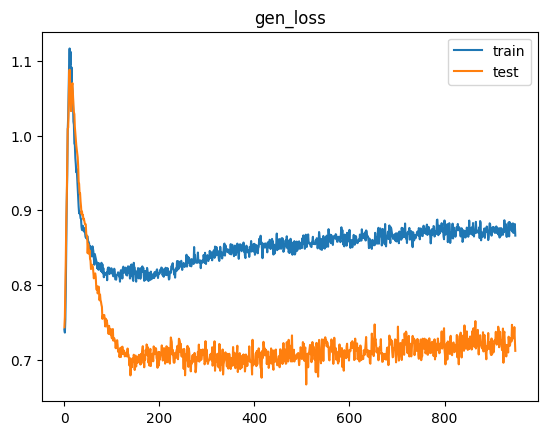

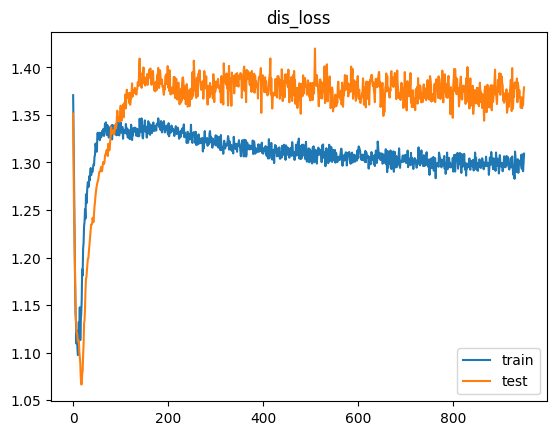

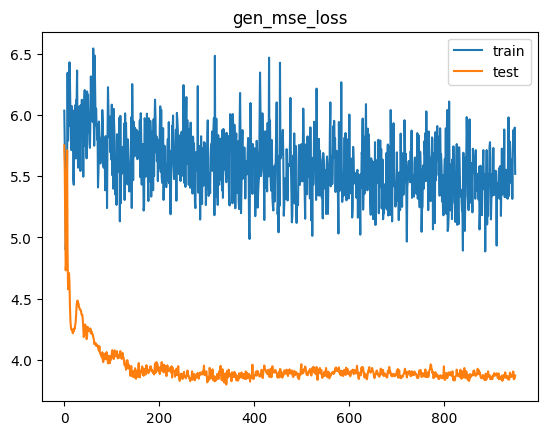

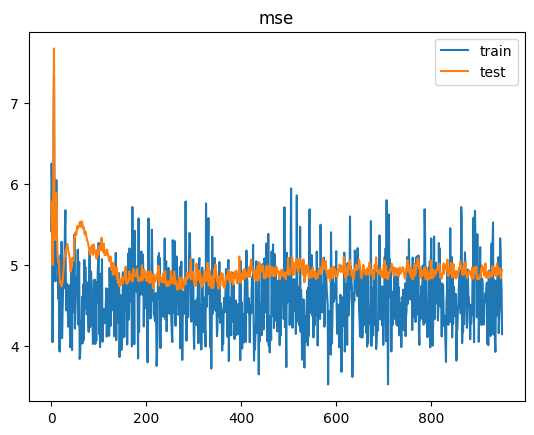

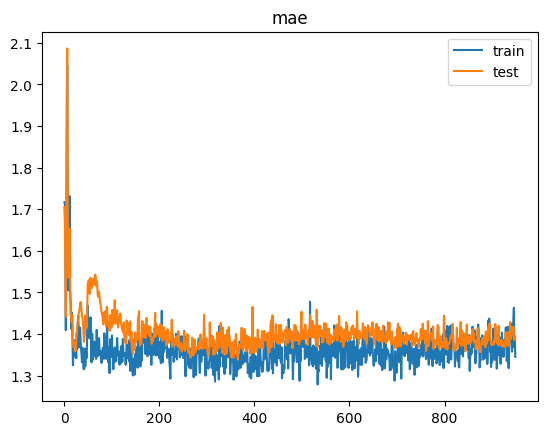

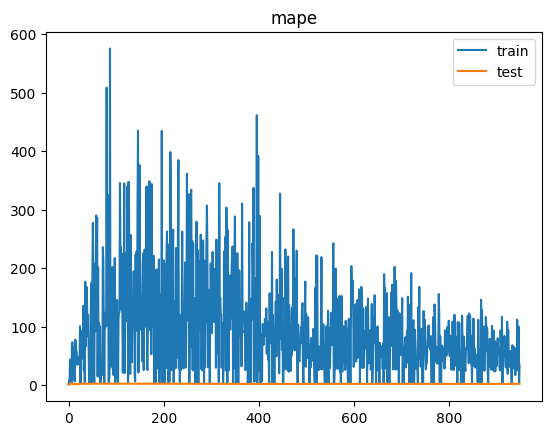

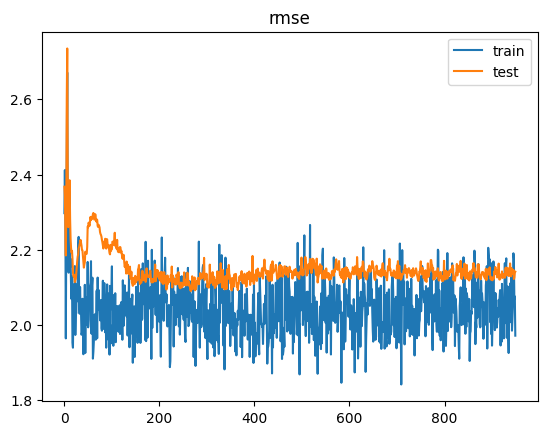

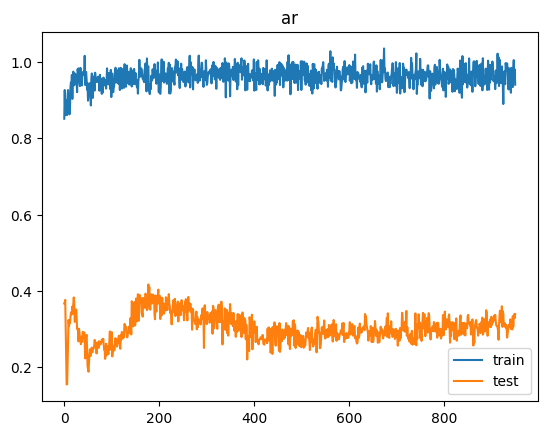

2/2 [==============================] - 1s 4ms/step


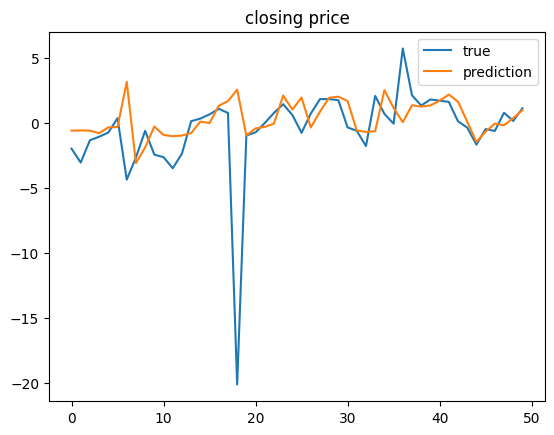

[MSE Baseline] train: 4.108123621210307  test: 4.68758521157695
Delta time with epochs = 950: 0:15:45.366365
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 5, 20)       1440        ['input_5[0][0]']                
 )                                                                                                
                                                                                                  
 concatenate_4 (Concatenate)    (None, 5, 27)        0           ['bidirectional_8[0][0]',        
                                                                  'input_5[0][0]']

Time for epoch 46 is 1.1192853450775146 sec Generator Loss: 0.8187928795814514,  Discriminator_loss: 1.3393585681915283
Time for epoch 47 is 1.1023485660552979 sec Generator Loss: 0.8194907903671265,  Discriminator_loss: 1.3334730863571167
Time for epoch 48 is 1.1450042724609375 sec Generator Loss: 0.8228718638420105,  Discriminator_loss: 1.331800937652588
Time for epoch 49 is 1.181839942932129 sec Generator Loss: 0.8186367750167847,  Discriminator_loss: 1.3375766277313232
Time for epoch 50 is 1.0066144466400146 sec Generator Loss: 0.8242807388305664,  Discriminator_loss: 1.3311352729797363
Time for epoch 51 is 0.981276273727417 sec Generator Loss: 0.8182968497276306,  Discriminator_loss: 1.3272950649261475
Time for epoch 52 is 1.0858421325683594 sec Generator Loss: 0.8235546350479126,  Discriminator_loss: 1.3397257328033447
Time for epoch 53 is 1.0294082164764404 sec Generator Loss: 0.8212195038795471,  Discriminator_loss: 1.3364994525909424
Time for epoch 54 is 1.0562536716461182 sec

Time for epoch 115 is 0.9950954914093018 sec Generator Loss: 0.8088261485099792,  Discriminator_loss: 1.3398038148880005
Time for epoch 116 is 1.0050513744354248 sec Generator Loss: 0.7979702353477478,  Discriminator_loss: 1.3447591066360474
Time for epoch 117 is 1.0119082927703857 sec Generator Loss: 0.7972551584243774,  Discriminator_loss: 1.3497931957244873
Time for epoch 118 is 0.9896063804626465 sec Generator Loss: 0.7876377701759338,  Discriminator_loss: 1.3497380018234253
Time for epoch 119 is 1.0017673969268799 sec Generator Loss: 0.7948928475379944,  Discriminator_loss: 1.3463228940963745
Time for epoch 120 is 0.992501974105835 sec Generator Loss: 0.7959523797035217,  Discriminator_loss: 1.3456417322158813
Time for epoch 121 is 0.9943604469299316 sec Generator Loss: 0.7968697547912598,  Discriminator_loss: 1.3404459953308105
Time for epoch 122 is 1.020324945449829 sec Generator Loss: 0.7994059324264526,  Discriminator_loss: 1.3507224321365356
Time for epoch 123 is 0.9940733909

Time for epoch 183 is 1.0402746200561523 sec Generator Loss: 0.7930080890655518,  Discriminator_loss: 1.3621671199798584
Time for epoch 184 is 1.2234578132629395 sec Generator Loss: 0.7825667262077332,  Discriminator_loss: 1.358805537223816
Time for epoch 185 is 1.0334491729736328 sec Generator Loss: 0.785781979560852,  Discriminator_loss: 1.3535548448562622
Time for epoch 186 is 1.0201811790466309 sec Generator Loss: 0.7803053855895996,  Discriminator_loss: 1.3540478944778442
Time for epoch 187 is 1.0249485969543457 sec Generator Loss: 0.78293776512146,  Discriminator_loss: 1.3529407978057861
Time for epoch 188 is 1.030033826828003 sec Generator Loss: 0.7834222316741943,  Discriminator_loss: 1.3551353216171265
Time for epoch 189 is 1.018906593322754 sec Generator Loss: 0.7834059596061707,  Discriminator_loss: 1.3558990955352783
Time for epoch 190 is 1.0862715244293213 sec Generator Loss: 0.7964646816253662,  Discriminator_loss: 1.349866509437561
Time for epoch 191 is 1.078037023544311

Time for epoch 251 is 0.9496757984161377 sec Generator Loss: 0.79897540807724,  Discriminator_loss: 1.3479652404785156
Time for epoch 252 is 0.96578049659729 sec Generator Loss: 0.7995006442070007,  Discriminator_loss: 1.3470127582550049
Time for epoch 253 is 0.9565370082855225 sec Generator Loss: 0.794897735118866,  Discriminator_loss: 1.3475874662399292
Time for epoch 254 is 0.978341817855835 sec Generator Loss: 0.7976547479629517,  Discriminator_loss: 1.343713641166687
Time for epoch 255 is 0.9653067588806152 sec Generator Loss: 0.7986828088760376,  Discriminator_loss: 1.3438928127288818
Time for epoch 256 is 0.9875242710113525 sec Generator Loss: 0.8002244234085083,  Discriminator_loss: 1.3435026407241821
Time for epoch 257 is 0.9922630786895752 sec Generator Loss: 0.7933299541473389,  Discriminator_loss: 1.3449631929397583
Time for epoch 258 is 0.9738922119140625 sec Generator Loss: 0.7944552302360535,  Discriminator_loss: 1.3419710397720337
Time for epoch 259 is 0.964664459228515

Time for epoch 320 is 1.1593189239501953 sec Generator Loss: 0.8111634850502014,  Discriminator_loss: 1.3359532356262207
Time for epoch 321 is 1.1547329425811768 sec Generator Loss: 0.8066675662994385,  Discriminator_loss: 1.3368585109710693
Time for epoch 322 is 1.074946403503418 sec Generator Loss: 0.8110369443893433,  Discriminator_loss: 1.3314999341964722
Time for epoch 323 is 1.0401363372802734 sec Generator Loss: 0.8118993639945984,  Discriminator_loss: 1.3354820013046265
Time for epoch 324 is 1.0206379890441895 sec Generator Loss: 0.8198596239089966,  Discriminator_loss: 1.3288204669952393
Time for epoch 325 is 1.041900634765625 sec Generator Loss: 0.81725013256073,  Discriminator_loss: 1.3310513496398926
Time for epoch 326 is 1.0158050060272217 sec Generator Loss: 0.8164091110229492,  Discriminator_loss: 1.3356043100357056
Time for epoch 327 is 1.0687050819396973 sec Generator Loss: 0.8138591051101685,  Discriminator_loss: 1.3326771259307861
Time for epoch 328 is 1.020651817321

Time for epoch 388 is 1.002669334411621 sec Generator Loss: 0.8346429467201233,  Discriminator_loss: 1.322640299797058
Time for epoch 389 is 0.9894936084747314 sec Generator Loss: 0.8275253772735596,  Discriminator_loss: 1.3287297487258911
Time for epoch 390 is 0.9999904632568359 sec Generator Loss: 0.823428750038147,  Discriminator_loss: 1.3320149183273315
Time for epoch 391 is 0.980140209197998 sec Generator Loss: 0.8198686838150024,  Discriminator_loss: 1.3386061191558838
Time for epoch 392 is 1.0146911144256592 sec Generator Loss: 0.8248189687728882,  Discriminator_loss: 1.325498104095459
Time for epoch 393 is 1.0403661727905273 sec Generator Loss: 0.8205989003181458,  Discriminator_loss: 1.3287296295166016
Time for epoch 394 is 1.0371448993682861 sec Generator Loss: 0.8191094398498535,  Discriminator_loss: 1.3255442380905151
Time for epoch 395 is 1.0395548343658447 sec Generator Loss: 0.8141241669654846,  Discriminator_loss: 1.3367321491241455
Time for epoch 396 is 1.0265302658081

Time for epoch 457 is 1.049917221069336 sec Generator Loss: 0.8308893442153931,  Discriminator_loss: 1.3242384195327759
Time for epoch 458 is 1.0400059223175049 sec Generator Loss: 0.825116753578186,  Discriminator_loss: 1.3181196451187134
Time for epoch 459 is 1.0646893978118896 sec Generator Loss: 0.836266279220581,  Discriminator_loss: 1.3125983476638794
Time for epoch 460 is 1.0647118091583252 sec Generator Loss: 0.8302209377288818,  Discriminator_loss: 1.3228051662445068
Time for epoch 461 is 1.0491836071014404 sec Generator Loss: 0.8377216458320618,  Discriminator_loss: 1.3217965364456177
Time for epoch 462 is 1.034106731414795 sec Generator Loss: 0.8358089327812195,  Discriminator_loss: 1.3242939710617065
Time for epoch 463 is 1.0038514137268066 sec Generator Loss: 0.8260695338249207,  Discriminator_loss: 1.3223532438278198
Time for epoch 464 is 1.0255811214447021 sec Generator Loss: 0.8349128365516663,  Discriminator_loss: 1.3263311386108398
Time for epoch 465 is 0.989733695983

Time for epoch 526 is 0.9906513690948486 sec Generator Loss: 0.8343822956085205,  Discriminator_loss: 1.3246220350265503
Time for epoch 527 is 1.0063741207122803 sec Generator Loss: 0.8294811844825745,  Discriminator_loss: 1.3208688497543335
Time for epoch 528 is 0.9882903099060059 sec Generator Loss: 0.8224233984947205,  Discriminator_loss: 1.3320112228393555
Time for epoch 529 is 0.9871551990509033 sec Generator Loss: 0.8361768126487732,  Discriminator_loss: 1.3187342882156372
Time for epoch 530 is 0.9905662536621094 sec Generator Loss: 0.8303855061531067,  Discriminator_loss: 1.3194518089294434
Time for epoch 531 is 0.997450590133667 sec Generator Loss: 0.8323343396186829,  Discriminator_loss: 1.317867398262024
Time for epoch 532 is 0.9988982677459717 sec Generator Loss: 0.8297114968299866,  Discriminator_loss: 1.3227723836898804
Time for epoch 533 is 0.9908366203308105 sec Generator Loss: 0.842025876045227,  Discriminator_loss: 1.3093640804290771
Time for epoch 534 is 0.99462866783

Time for epoch 595 is 0.9801199436187744 sec Generator Loss: 0.8426865935325623,  Discriminator_loss: 1.3138513565063477
Time for epoch 596 is 0.992215633392334 sec Generator Loss: 0.8520327806472778,  Discriminator_loss: 1.3095570802688599
Time for epoch 597 is 1.0179595947265625 sec Generator Loss: 0.8449148535728455,  Discriminator_loss: 1.318260908126831
Time for epoch 598 is 0.9959156513214111 sec Generator Loss: 0.8379653692245483,  Discriminator_loss: 1.3144731521606445
Time for epoch 599 is 1.0133016109466553 sec Generator Loss: 0.8414041996002197,  Discriminator_loss: 1.3149546384811401
Time for epoch 600 is 1.0122990608215332 sec Generator Loss: 0.845075249671936,  Discriminator_loss: 1.3184208869934082
Time for epoch 601 is 1.0123188495635986 sec Generator Loss: 0.8448023200035095,  Discriminator_loss: 1.3187880516052246
Time for epoch 602 is 1.0039339065551758 sec Generator Loss: 0.8435535430908203,  Discriminator_loss: 1.3224759101867676
Time for epoch 603 is 1.00424695014

Time for epoch 664 is 1.1755077838897705 sec Generator Loss: 0.847604513168335,  Discriminator_loss: 1.311327338218689
Time for epoch 665 is 1.1644504070281982 sec Generator Loss: 0.8450338840484619,  Discriminator_loss: 1.3098788261413574
Time for epoch 666 is 1.1623260974884033 sec Generator Loss: 0.849827229976654,  Discriminator_loss: 1.319502830505371
Time for epoch 667 is 1.1582517623901367 sec Generator Loss: 0.8472240567207336,  Discriminator_loss: 1.3161087036132812
Time for epoch 668 is 1.171410322189331 sec Generator Loss: 0.8570815920829773,  Discriminator_loss: 1.3137520551681519
Time for epoch 669 is 1.209925889968872 sec Generator Loss: 0.8519788384437561,  Discriminator_loss: 1.3170521259307861
Time for epoch 670 is 1.2198991775512695 sec Generator Loss: 0.8456376791000366,  Discriminator_loss: 1.3156787157058716
Time for epoch 671 is 1.1829338073730469 sec Generator Loss: 0.8591527342796326,  Discriminator_loss: 1.3106986284255981
Time for epoch 672 is 1.17155289649963

Time for epoch 733 is 1.029160976409912 sec Generator Loss: 0.8502384424209595,  Discriminator_loss: 1.316277027130127
Time for epoch 734 is 1.024656057357788 sec Generator Loss: 0.8367027640342712,  Discriminator_loss: 1.32077956199646
Time for epoch 735 is 1.0354468822479248 sec Generator Loss: 0.8527881503105164,  Discriminator_loss: 1.3108656406402588
Time for epoch 736 is 1.044848918914795 sec Generator Loss: 0.8413363099098206,  Discriminator_loss: 1.3171494007110596
Time for epoch 737 is 1.0256834030151367 sec Generator Loss: 0.8464565277099609,  Discriminator_loss: 1.3092961311340332
Time for epoch 738 is 1.06569504737854 sec Generator Loss: 0.8458353281021118,  Discriminator_loss: 1.314523696899414
Time for epoch 739 is 1.0622124671936035 sec Generator Loss: 0.8483603596687317,  Discriminator_loss: 1.3193429708480835
Time for epoch 740 is 1.0397944450378418 sec Generator Loss: 0.8441780209541321,  Discriminator_loss: 1.3172979354858398
Time for epoch 741 is 1.03999924659729 se

Time for epoch 802 is 1.0572025775909424 sec Generator Loss: 0.8541215658187866,  Discriminator_loss: 1.3207145929336548
Time for epoch 803 is 1.061610460281372 sec Generator Loss: 0.85064297914505,  Discriminator_loss: 1.3101156949996948
Time for epoch 804 is 1.0740995407104492 sec Generator Loss: 0.8573747873306274,  Discriminator_loss: 1.314418911933899
Time for epoch 805 is 1.195511817932129 sec Generator Loss: 0.8394805192947388,  Discriminator_loss: 1.3263182640075684
Time for epoch 806 is 1.2310717105865479 sec Generator Loss: 0.8408048152923584,  Discriminator_loss: 1.3198931217193604
Time for epoch 807 is 1.1137340068817139 sec Generator Loss: 0.847156286239624,  Discriminator_loss: 1.3177707195281982
Time for epoch 808 is 1.121762752532959 sec Generator Loss: 0.854753851890564,  Discriminator_loss: 1.3164126873016357
Time for epoch 809 is 1.1614093780517578 sec Generator Loss: 0.8447408080101013,  Discriminator_loss: 1.316473364830017
Time for epoch 810 is 1.1546037197113037 

Time for epoch 871 is 0.9909939765930176 sec Generator Loss: 0.8433921933174133,  Discriminator_loss: 1.3174761533737183
Time for epoch 872 is 1.013491153717041 sec Generator Loss: 0.8522194027900696,  Discriminator_loss: 1.3199199438095093
Time for epoch 873 is 1.0067157745361328 sec Generator Loss: 0.854179322719574,  Discriminator_loss: 1.3175632953643799
Time for epoch 874 is 1.0519578456878662 sec Generator Loss: 0.8490096926689148,  Discriminator_loss: 1.3230297565460205
Time for epoch 875 is 1.0457940101623535 sec Generator Loss: 0.8505663871765137,  Discriminator_loss: 1.3175150156021118
Time for epoch 876 is 1.009077787399292 sec Generator Loss: 0.8527693152427673,  Discriminator_loss: 1.3088065385818481
Time for epoch 877 is 1.011042833328247 sec Generator Loss: 0.8446226119995117,  Discriminator_loss: 1.3255983591079712
Time for epoch 878 is 1.0142621994018555 sec Generator Loss: 0.8456007242202759,  Discriminator_loss: 1.3192143440246582
Time for epoch 879 is 1.014728546142

Time for epoch 940 is 1.013895034790039 sec Generator Loss: 0.8508997559547424,  Discriminator_loss: 1.3115054368972778
Time for epoch 941 is 1.0097017288208008 sec Generator Loss: 0.8553737998008728,  Discriminator_loss: 1.3218708038330078
Time for epoch 942 is 1.0262055397033691 sec Generator Loss: 0.8614059686660767,  Discriminator_loss: 1.2997530698776245
Time for epoch 943 is 1.0383248329162598 sec Generator Loss: 0.8527253866195679,  Discriminator_loss: 1.3115183115005493
Time for epoch 944 is 1.0180680751800537 sec Generator Loss: 0.8569409251213074,  Discriminator_loss: 1.3096649646759033
Time for epoch 945 is 1.0205609798431396 sec Generator Loss: 0.8586292266845703,  Discriminator_loss: 1.3162293434143066
Time for epoch 946 is 1.0223512649536133 sec Generator Loss: 0.8497883081436157,  Discriminator_loss: 1.3237829208374023
Time for epoch 947 is 1.027557134628296 sec Generator Loss: 0.8522966504096985,  Discriminator_loss: 1.3201264142990112
Time for epoch 948 is 1.0148923397

Time for epoch 1008 is 1.0777006149291992 sec Generator Loss: 0.8449713587760925,  Discriminator_loss: 1.322880506515503
Time for epoch 1009 is 1.1669950485229492 sec Generator Loss: 0.8462012410163879,  Discriminator_loss: 1.3226865530014038
Time for epoch 1010 is 1.099815845489502 sec Generator Loss: 0.8448454141616821,  Discriminator_loss: 1.3236279487609863
Time for epoch 1011 is 1.1017429828643799 sec Generator Loss: 0.853179931640625,  Discriminator_loss: 1.319113850593567
Time for epoch 1012 is 1.3510494232177734 sec Generator Loss: 0.8595563173294067,  Discriminator_loss: 1.308363914489746
Time for epoch 1013 is 1.2304117679595947 sec Generator Loss: 0.8581542372703552,  Discriminator_loss: 1.3117517232894897
Time for epoch 1014 is 1.1213243007659912 sec Generator Loss: 0.8572930693626404,  Discriminator_loss: 1.3203251361846924
Time for epoch 1015 is 1.0877854824066162 sec Generator Loss: 0.8575558662414551,  Discriminator_loss: 1.3187109231948853
Time for epoch 1016 is 1.1257

Time for epoch 1076 is 1.1421926021575928 sec Generator Loss: 0.8523405194282532,  Discriminator_loss: 1.3141382932662964
Time for epoch 1077 is 1.0855600833892822 sec Generator Loss: 0.8550044298171997,  Discriminator_loss: 1.3176690340042114
Time for epoch 1078 is 1.0889570713043213 sec Generator Loss: 0.8551297187805176,  Discriminator_loss: 1.3179062604904175
Time for epoch 1079 is 1.1252250671386719 sec Generator Loss: 0.8575605154037476,  Discriminator_loss: 1.3142986297607422
Time for epoch 1080 is 1.0918245315551758 sec Generator Loss: 0.854924738407135,  Discriminator_loss: 1.3183308839797974
Time for epoch 1081 is 1.0464680194854736 sec Generator Loss: 0.859564483165741,  Discriminator_loss: 1.3147449493408203
Time for epoch 1082 is 1.078244686126709 sec Generator Loss: 0.8618219494819641,  Discriminator_loss: 1.312924861907959
Time for epoch 1083 is 1.0572171211242676 sec Generator Loss: 0.8428328037261963,  Discriminator_loss: 1.3198713064193726
Time for epoch 1084 is 1.055

Time for epoch 1144 is 1.0496435165405273 sec Generator Loss: 0.8499192595481873,  Discriminator_loss: 1.3252004384994507
Time for epoch 1145 is 1.0432536602020264 sec Generator Loss: 0.8612682223320007,  Discriminator_loss: 1.3170459270477295
Time for epoch 1146 is 1.0290677547454834 sec Generator Loss: 0.849464476108551,  Discriminator_loss: 1.3209508657455444
Time for epoch 1147 is 1.0239179134368896 sec Generator Loss: 0.8542457222938538,  Discriminator_loss: 1.3101662397384644
Time for epoch 1148 is 1.0382499694824219 sec Generator Loss: 0.844775378704071,  Discriminator_loss: 1.3145945072174072
Time for epoch 1149 is 1.0513548851013184 sec Generator Loss: 0.8455682396888733,  Discriminator_loss: 1.328852653503418
Time for epoch 1150 is 1.0502564907073975 sec Generator Loss: 0.8493536710739136,  Discriminator_loss: 1.3147847652435303
Time for epoch 1151 is 1.0346369743347168 sec Generator Loss: 0.8511031270027161,  Discriminator_loss: 1.3170822858810425
Time for epoch 1152 is 1.12

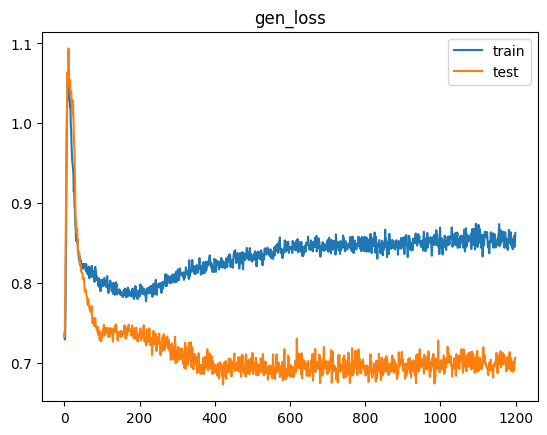

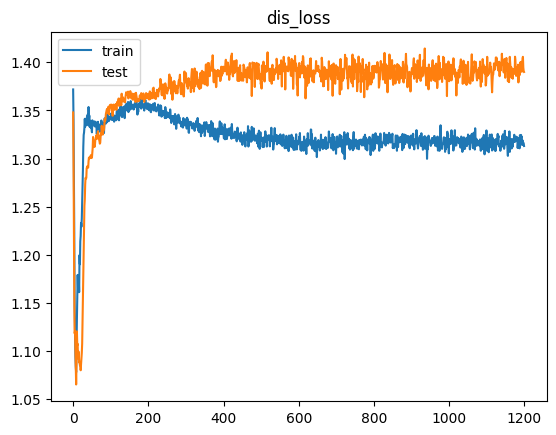

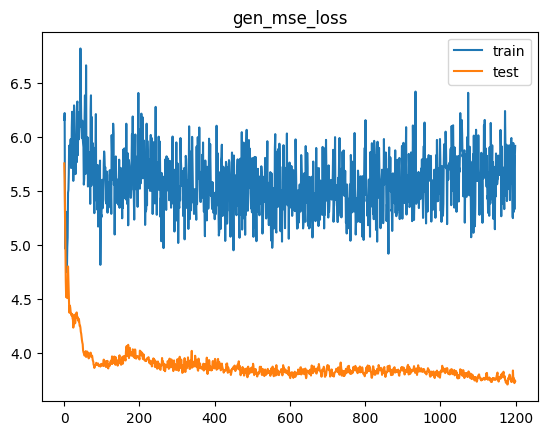

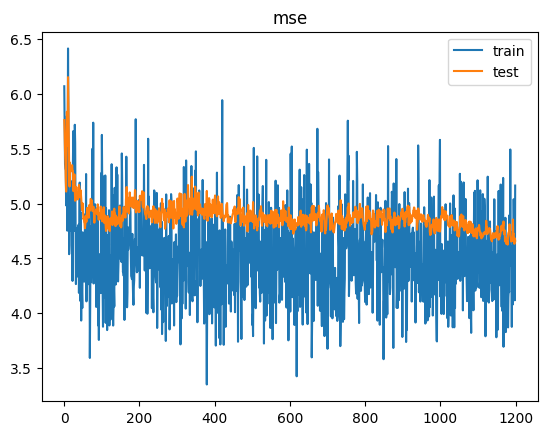

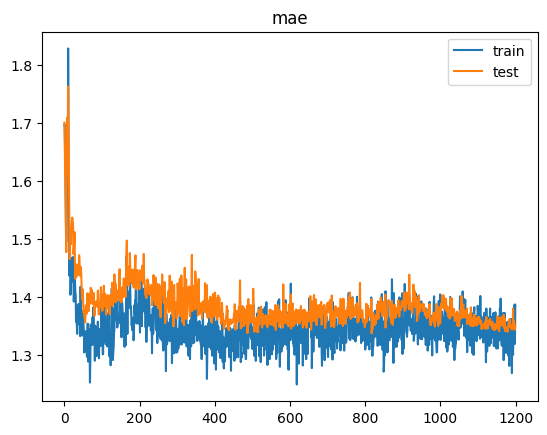

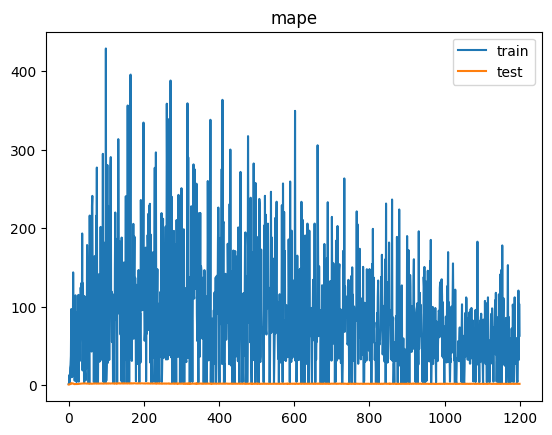

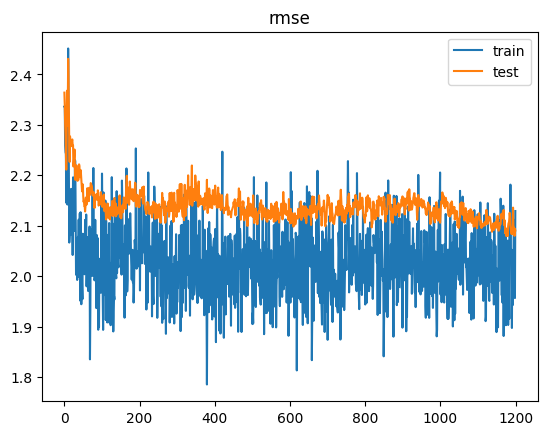

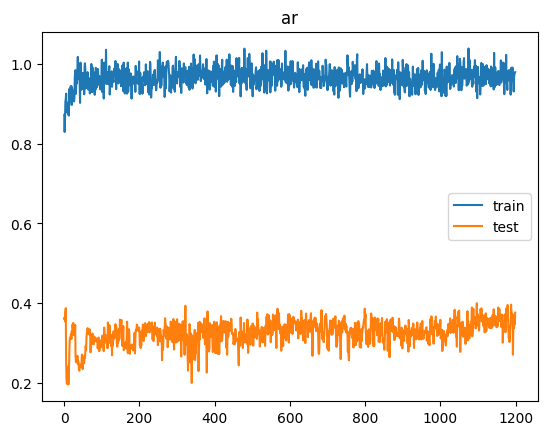

2/2 [==============================] - 1s 5ms/step


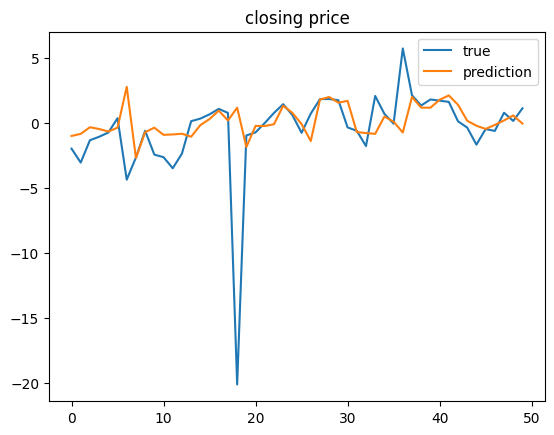

[MSE Baseline] train: 3.7003335600804146  test: 4.68758521157695
Delta time with epochs = 1200: 0:21:28.382389
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_10 (Bidirectiona  (None, 5, 20)       1440        ['input_6[0][0]']                
 l)                                                                                               
                                                                                                  
 concatenate_5 (Concatenate)    (None, 5, 27)        0           ['bidirectional_10[0][0]',       
                                                                  'input_6[0][0]

Time for epoch 46 is 1.1702265739440918 sec Generator Loss: 0.8470578193664551,  Discriminator_loss: 1.3210656642913818
Time for epoch 47 is 1.2122554779052734 sec Generator Loss: 0.8395043015480042,  Discriminator_loss: 1.3264611959457397
Time for epoch 48 is 1.2165775299072266 sec Generator Loss: 0.844875693321228,  Discriminator_loss: 1.3222169876098633
Time for epoch 49 is 1.218163013458252 sec Generator Loss: 0.8465466499328613,  Discriminator_loss: 1.327474594116211
Time for epoch 50 is 1.2164747714996338 sec Generator Loss: 0.8339152932167053,  Discriminator_loss: 1.323132872581482
Time for epoch 51 is 1.1236965656280518 sec Generator Loss: 0.8388810753822327,  Discriminator_loss: 1.3229715824127197
Time for epoch 52 is 1.0631275177001953 sec Generator Loss: 0.8361384272575378,  Discriminator_loss: 1.3318623304367065
Time for epoch 53 is 1.2028660774230957 sec Generator Loss: 0.828706681728363,  Discriminator_loss: 1.332370400428772
Time for epoch 54 is 1.127103567123413 sec Gen

Time for epoch 115 is 1.1799845695495605 sec Generator Loss: 0.8228306770324707,  Discriminator_loss: 1.3359407186508179
Time for epoch 116 is 1.144930362701416 sec Generator Loss: 0.8279747366905212,  Discriminator_loss: 1.336285948753357
Time for epoch 117 is 1.087334394454956 sec Generator Loss: 0.8259966969490051,  Discriminator_loss: 1.3311729431152344
Time for epoch 118 is 1.1376099586486816 sec Generator Loss: 0.8141974210739136,  Discriminator_loss: 1.3369652032852173
Time for epoch 119 is 1.092846155166626 sec Generator Loss: 0.8276771306991577,  Discriminator_loss: 1.3329670429229736
Time for epoch 120 is 1.07273530960083 sec Generator Loss: 0.8277862668037415,  Discriminator_loss: 1.3321644067764282
Time for epoch 121 is 1.11513352394104 sec Generator Loss: 0.8177064061164856,  Discriminator_loss: 1.3414448499679565
Time for epoch 122 is 1.0989100933074951 sec Generator Loss: 0.8218452334403992,  Discriminator_loss: 1.3327287435531616
Time for epoch 123 is 1.16029691696167 s

Time for epoch 184 is 1.318054437637329 sec Generator Loss: 0.8150578737258911,  Discriminator_loss: 1.342491865158081
Time for epoch 185 is 1.113433599472046 sec Generator Loss: 0.8154192566871643,  Discriminator_loss: 1.342632532119751
Time for epoch 186 is 1.1585710048675537 sec Generator Loss: 0.8034981489181519,  Discriminator_loss: 1.3448948860168457
Time for epoch 187 is 1.079887866973877 sec Generator Loss: 0.8034465909004211,  Discriminator_loss: 1.3465549945831299
Time for epoch 188 is 1.2933216094970703 sec Generator Loss: 0.8110642433166504,  Discriminator_loss: 1.3400230407714844
Time for epoch 189 is 1.1245954036712646 sec Generator Loss: 0.8006748557090759,  Discriminator_loss: 1.3502411842346191
Time for epoch 190 is 1.0732014179229736 sec Generator Loss: 0.805385172367096,  Discriminator_loss: 1.3399794101715088
Time for epoch 191 is 1.1082983016967773 sec Generator Loss: 0.8186694979667664,  Discriminator_loss: 1.338028073310852
Time for epoch 192 is 1.160333871841430

Time for epoch 253 is 1.2116811275482178 sec Generator Loss: 0.8179677128791809,  Discriminator_loss: 1.3366780281066895
Time for epoch 254 is 1.0412254333496094 sec Generator Loss: 0.8234033584594727,  Discriminator_loss: 1.341558814048767
Time for epoch 255 is 1.096874713897705 sec Generator Loss: 0.8193116784095764,  Discriminator_loss: 1.3409301042556763
Time for epoch 256 is 1.069626808166504 sec Generator Loss: 0.8245667815208435,  Discriminator_loss: 1.3274418115615845
Time for epoch 257 is 1.0774874687194824 sec Generator Loss: 0.8224604725837708,  Discriminator_loss: 1.333484172821045
Time for epoch 258 is 1.0659465789794922 sec Generator Loss: 0.8230525851249695,  Discriminator_loss: 1.3361430168151855
Time for epoch 259 is 1.2164344787597656 sec Generator Loss: 0.8132339715957642,  Discriminator_loss: 1.3391354084014893
Time for epoch 260 is 1.236257791519165 sec Generator Loss: 0.816426694393158,  Discriminator_loss: 1.3413013219833374
Time for epoch 261 is 1.25884175300598

Time for epoch 322 is 1.0658249855041504 sec Generator Loss: 0.8172031044960022,  Discriminator_loss: 1.3358813524246216
Time for epoch 323 is 1.0484161376953125 sec Generator Loss: 0.8286812901496887,  Discriminator_loss: 1.3295321464538574
Time for epoch 324 is 1.0563404560089111 sec Generator Loss: 0.8279865980148315,  Discriminator_loss: 1.3256795406341553
Time for epoch 325 is 1.0482428073883057 sec Generator Loss: 0.8324840664863586,  Discriminator_loss: 1.329363465309143
Time for epoch 326 is 1.0983755588531494 sec Generator Loss: 0.8219721913337708,  Discriminator_loss: 1.3364177942276
Time for epoch 327 is 1.1310429573059082 sec Generator Loss: 0.8197377920150757,  Discriminator_loss: 1.3368180990219116
Time for epoch 328 is 1.1162939071655273 sec Generator Loss: 0.8378540277481079,  Discriminator_loss: 1.323670506477356
Time for epoch 329 is 1.120274305343628 sec Generator Loss: 0.8252407312393188,  Discriminator_loss: 1.3297338485717773
Time for epoch 330 is 1.13340806961059

Time for epoch 391 is 1.1371731758117676 sec Generator Loss: 0.8501721620559692,  Discriminator_loss: 1.3151159286499023
Time for epoch 392 is 1.1146063804626465 sec Generator Loss: 0.8340408802032471,  Discriminator_loss: 1.3262523412704468
Time for epoch 393 is 1.1885876655578613 sec Generator Loss: 0.8357962965965271,  Discriminator_loss: 1.3263875246047974
Time for epoch 394 is 1.3509950637817383 sec Generator Loss: 0.8288492560386658,  Discriminator_loss: 1.334704875946045
Time for epoch 395 is 1.3081684112548828 sec Generator Loss: 0.8502600193023682,  Discriminator_loss: 1.3090806007385254
Time for epoch 396 is 1.107485055923462 sec Generator Loss: 0.838324785232544,  Discriminator_loss: 1.3197659254074097
Time for epoch 397 is 1.140986680984497 sec Generator Loss: 0.8421617746353149,  Discriminator_loss: 1.3194981813430786
Time for epoch 398 is 1.1350617408752441 sec Generator Loss: 0.833095908164978,  Discriminator_loss: 1.321529746055603
Time for epoch 399 is 1.21341919898986

Time for epoch 460 is 1.2892732620239258 sec Generator Loss: 0.8434309363365173,  Discriminator_loss: 1.3219611644744873
Time for epoch 461 is 1.3504741191864014 sec Generator Loss: 0.8391864895820618,  Discriminator_loss: 1.3176088333129883
Time for epoch 462 is 1.2120227813720703 sec Generator Loss: 0.8464486002922058,  Discriminator_loss: 1.323867678642273
Time for epoch 463 is 1.2904901504516602 sec Generator Loss: 0.8426826000213623,  Discriminator_loss: 1.3206684589385986
Time for epoch 464 is 1.2500183582305908 sec Generator Loss: 0.8492599725723267,  Discriminator_loss: 1.310951828956604
Time for epoch 465 is 1.2109689712524414 sec Generator Loss: 0.8443137407302856,  Discriminator_loss: 1.3166489601135254
Time for epoch 466 is 1.2256736755371094 sec Generator Loss: 0.8403661847114563,  Discriminator_loss: 1.3310045003890991
Time for epoch 467 is 1.243166208267212 sec Generator Loss: 0.8378587961196899,  Discriminator_loss: 1.3263086080551147
Time for epoch 468 is 1.25730943679

Time for epoch 528 is 1.3367321491241455 sec Generator Loss: 0.8495107889175415,  Discriminator_loss: 1.319654107093811
Time for epoch 529 is 1.191260814666748 sec Generator Loss: 0.8396640419960022,  Discriminator_loss: 1.317443609237671
Time for epoch 530 is 1.210442066192627 sec Generator Loss: 0.8465880155563354,  Discriminator_loss: 1.317671298980713
Time for epoch 531 is 1.269423246383667 sec Generator Loss: 0.8548524975776672,  Discriminator_loss: 1.3180620670318604
Time for epoch 532 is 1.2278814315795898 sec Generator Loss: 0.8332969546318054,  Discriminator_loss: 1.3316441774368286
Time for epoch 533 is 1.1357216835021973 sec Generator Loss: 0.8495327830314636,  Discriminator_loss: 1.3163607120513916
Time for epoch 534 is 1.1583454608917236 sec Generator Loss: 0.8414037823677063,  Discriminator_loss: 1.3168044090270996
Time for epoch 535 is 1.166562557220459 sec Generator Loss: 0.8509736061096191,  Discriminator_loss: 1.3170945644378662
Time for epoch 536 is 1.151714563369751

Time for epoch 597 is 1.1442773342132568 sec Generator Loss: 0.8586347103118896,  Discriminator_loss: 1.3140267133712769
Time for epoch 598 is 1.1519460678100586 sec Generator Loss: 0.8557853102684021,  Discriminator_loss: 1.3233673572540283
Time for epoch 599 is 1.1676578521728516 sec Generator Loss: 0.8493654727935791,  Discriminator_loss: 1.317984938621521
Time for epoch 600 is 1.1456074714660645 sec Generator Loss: 0.849392294883728,  Discriminator_loss: 1.323314905166626
Time for epoch 601 is 1.1502258777618408 sec Generator Loss: 0.8525216579437256,  Discriminator_loss: 1.307089924812317
Time for epoch 602 is 1.1469128131866455 sec Generator Loss: 0.8537273406982422,  Discriminator_loss: 1.3189737796783447
Time for epoch 603 is 1.1826817989349365 sec Generator Loss: 0.8529719114303589,  Discriminator_loss: 1.3198002576828003
Time for epoch 604 is 1.1637887954711914 sec Generator Loss: 0.8359524011611938,  Discriminator_loss: 1.3274116516113281
Time for epoch 605 is 1.162464380264

Time for epoch 666 is 1.0970394611358643 sec Generator Loss: 0.84998619556427,  Discriminator_loss: 1.320403814315796
Time for epoch 667 is 1.137176275253296 sec Generator Loss: 0.8372067809104919,  Discriminator_loss: 1.3206422328948975
Time for epoch 668 is 1.0997557640075684 sec Generator Loss: 0.8568165302276611,  Discriminator_loss: 1.3201326131820679
Time for epoch 669 is 1.0964694023132324 sec Generator Loss: 0.845929741859436,  Discriminator_loss: 1.3163087368011475
Time for epoch 670 is 1.0922236442565918 sec Generator Loss: 0.8599608540534973,  Discriminator_loss: 1.3074220418930054
Time for epoch 671 is 1.1024115085601807 sec Generator Loss: 0.8592997789382935,  Discriminator_loss: 1.3140958547592163
Time for epoch 672 is 1.1018426418304443 sec Generator Loss: 0.8589504361152649,  Discriminator_loss: 1.3185334205627441
Time for epoch 673 is 1.1140599250793457 sec Generator Loss: 0.8604003190994263,  Discriminator_loss: 1.3092842102050781
Time for epoch 674 is 1.1138970851898

Time for epoch 735 is 1.2504417896270752 sec Generator Loss: 0.8545451760292053,  Discriminator_loss: 1.3163576126098633
Time for epoch 736 is 1.2656686305999756 sec Generator Loss: 0.8701924681663513,  Discriminator_loss: 1.302975058555603
Time for epoch 737 is 1.1810345649719238 sec Generator Loss: 0.8618413209915161,  Discriminator_loss: 1.3114773035049438
Time for epoch 738 is 1.186023235321045 sec Generator Loss: 0.8464497327804565,  Discriminator_loss: 1.3190480470657349
Time for epoch 739 is 1.1787490844726562 sec Generator Loss: 0.8569042682647705,  Discriminator_loss: 1.3093595504760742
Time for epoch 740 is 1.1617200374603271 sec Generator Loss: 0.8555933237075806,  Discriminator_loss: 1.3152447938919067
Time for epoch 741 is 1.1739375591278076 sec Generator Loss: 0.8540674448013306,  Discriminator_loss: 1.3112547397613525
Time for epoch 742 is 1.1869113445281982 sec Generator Loss: 0.8436525464057922,  Discriminator_loss: 1.3253910541534424
Time for epoch 743 is 1.1900441646

Time for epoch 804 is 1.2324652671813965 sec Generator Loss: 0.8613549470901489,  Discriminator_loss: 1.3042314052581787
Time for epoch 805 is 1.2037231922149658 sec Generator Loss: 0.8536102175712585,  Discriminator_loss: 1.3187772035598755
Time for epoch 806 is 1.1018319129943848 sec Generator Loss: 0.876472532749176,  Discriminator_loss: 1.2998387813568115
Time for epoch 807 is 1.1845698356628418 sec Generator Loss: 0.8581701517105103,  Discriminator_loss: 1.3188340663909912
Time for epoch 808 is 1.1945817470550537 sec Generator Loss: 0.845711886882782,  Discriminator_loss: 1.3239946365356445
Time for epoch 809 is 1.1204378604888916 sec Generator Loss: 0.8506999015808105,  Discriminator_loss: 1.3120020627975464
Time for epoch 810 is 1.1367225646972656 sec Generator Loss: 0.8630840182304382,  Discriminator_loss: 1.312243103981018
Time for epoch 811 is 1.111936330795288 sec Generator Loss: 0.8566118478775024,  Discriminator_loss: 1.3146640062332153
Time for epoch 812 is 1.203296184539

Time for epoch 873 is 1.311319351196289 sec Generator Loss: 0.8476435542106628,  Discriminator_loss: 1.3128111362457275
Time for epoch 874 is 1.242940902709961 sec Generator Loss: 0.8485699892044067,  Discriminator_loss: 1.3185933828353882
Time for epoch 875 is 1.2244491577148438 sec Generator Loss: 0.8651221990585327,  Discriminator_loss: 1.3081936836242676
Time for epoch 876 is 1.249208927154541 sec Generator Loss: 0.8634123802185059,  Discriminator_loss: 1.3143420219421387
Time for epoch 877 is 1.2415955066680908 sec Generator Loss: 0.859355628490448,  Discriminator_loss: 1.3084144592285156
Time for epoch 878 is 1.2677714824676514 sec Generator Loss: 0.864757239818573,  Discriminator_loss: 1.3149341344833374
Time for epoch 879 is 1.2658088207244873 sec Generator Loss: 0.8654783964157104,  Discriminator_loss: 1.3121851682662964
Time for epoch 880 is 1.2606680393218994 sec Generator Loss: 0.8705719113349915,  Discriminator_loss: 1.3072738647460938
Time for epoch 881 is 1.2308864593505

Time for epoch 942 is 1.263127326965332 sec Generator Loss: 0.8562297821044922,  Discriminator_loss: 1.314558982849121
Time for epoch 943 is 1.265294075012207 sec Generator Loss: 0.8600635528564453,  Discriminator_loss: 1.3164759874343872
Time for epoch 944 is 1.2768292427062988 sec Generator Loss: 0.8499517440795898,  Discriminator_loss: 1.3227359056472778
Time for epoch 945 is 1.2353124618530273 sec Generator Loss: 0.8461116552352905,  Discriminator_loss: 1.323394536972046
Time for epoch 946 is 1.262171745300293 sec Generator Loss: 0.8473779559135437,  Discriminator_loss: 1.3181068897247314
Time for epoch 947 is 1.2576472759246826 sec Generator Loss: 0.8670265078544617,  Discriminator_loss: 1.3105121850967407
Time for epoch 948 is 1.2527120113372803 sec Generator Loss: 0.8500970602035522,  Discriminator_loss: 1.3270246982574463
Time for epoch 949 is 1.278325080871582 sec Generator Loss: 0.8500936031341553,  Discriminator_loss: 1.3218402862548828
Time for epoch 950 is 1.24408555030822

Time for epoch 1010 is 1.298593521118164 sec Generator Loss: 0.8578047156333923,  Discriminator_loss: 1.3179935216903687
Time for epoch 1011 is 1.301276683807373 sec Generator Loss: 0.8683252334594727,  Discriminator_loss: 1.3059372901916504
Time for epoch 1012 is 1.304460048675537 sec Generator Loss: 0.859765350818634,  Discriminator_loss: 1.3147052526474
Time for epoch 1013 is 1.3842761516571045 sec Generator Loss: 0.8672868013381958,  Discriminator_loss: 1.3150032758712769
Time for epoch 1014 is 1.2958300113677979 sec Generator Loss: 0.8616275787353516,  Discriminator_loss: 1.3135154247283936
Time for epoch 1015 is 1.2184410095214844 sec Generator Loss: 0.8635168671607971,  Discriminator_loss: 1.3149194717407227
Time for epoch 1016 is 1.3214433193206787 sec Generator Loss: 0.8441333174705505,  Discriminator_loss: 1.3228942155838013
Time for epoch 1017 is 1.2724676132202148 sec Generator Loss: 0.8514989614486694,  Discriminator_loss: 1.3174588680267334
Time for epoch 1018 is 1.220000

Time for epoch 1078 is 1.350968360900879 sec Generator Loss: 0.8644199967384338,  Discriminator_loss: 1.3178163766860962
Time for epoch 1079 is 1.2951686382293701 sec Generator Loss: 0.8480806946754456,  Discriminator_loss: 1.3273026943206787
Time for epoch 1080 is 1.2353873252868652 sec Generator Loss: 0.8530321717262268,  Discriminator_loss: 1.3162561655044556
Time for epoch 1081 is 1.2448663711547852 sec Generator Loss: 0.8493643403053284,  Discriminator_loss: 1.3215574026107788
Time for epoch 1082 is 1.2827386856079102 sec Generator Loss: 0.8623171448707581,  Discriminator_loss: 1.3187345266342163
Time for epoch 1083 is 1.2501122951507568 sec Generator Loss: 0.8589240312576294,  Discriminator_loss: 1.318475604057312
Time for epoch 1084 is 1.2967934608459473 sec Generator Loss: 0.8595243096351624,  Discriminator_loss: 1.314687967300415
Time for epoch 1085 is 1.4994850158691406 sec Generator Loss: 0.8598247170448303,  Discriminator_loss: 1.3201382160186768
Time for epoch 1086 is 1.28

Time for epoch 1146 is 1.2764856815338135 sec Generator Loss: 0.8406583070755005,  Discriminator_loss: 1.321616768836975
Time for epoch 1147 is 1.2539262771606445 sec Generator Loss: 0.8572052121162415,  Discriminator_loss: 1.3169310092926025
Time for epoch 1148 is 1.2931559085845947 sec Generator Loss: 0.8530126810073853,  Discriminator_loss: 1.31829833984375
Time for epoch 1149 is 1.3063178062438965 sec Generator Loss: 0.8521835803985596,  Discriminator_loss: 1.3204020261764526
Time for epoch 1150 is 1.3060762882232666 sec Generator Loss: 0.859682559967041,  Discriminator_loss: 1.3195995092391968
Time for epoch 1151 is 1.3361055850982666 sec Generator Loss: 0.8634039163589478,  Discriminator_loss: 1.3097717761993408
Time for epoch 1152 is 1.2342419624328613 sec Generator Loss: 0.8577907085418701,  Discriminator_loss: 1.3159576654434204
Time for epoch 1153 is 1.3104074001312256 sec Generator Loss: 0.8554763793945312,  Discriminator_loss: 1.3173232078552246
Time for epoch 1154 is 1.368

Time for epoch 1214 is 1.2288784980773926 sec Generator Loss: 0.8606585264205933,  Discriminator_loss: 1.3165504932403564
Time for epoch 1215 is 1.257420539855957 sec Generator Loss: 0.8623049855232239,  Discriminator_loss: 1.3100677728652954
Time for epoch 1216 is 1.2679569721221924 sec Generator Loss: 0.8631343841552734,  Discriminator_loss: 1.321101427078247
Time for epoch 1217 is 1.260270118713379 sec Generator Loss: 0.8589802980422974,  Discriminator_loss: 1.3190968036651611
Time for epoch 1218 is 1.2563238143920898 sec Generator Loss: 0.8456331491470337,  Discriminator_loss: 1.3226492404937744
Time for epoch 1219 is 1.2450015544891357 sec Generator Loss: 0.8536396622657776,  Discriminator_loss: 1.3126798868179321
Time for epoch 1220 is 1.2683541774749756 sec Generator Loss: 0.8556386232376099,  Discriminator_loss: 1.3168917894363403
Time for epoch 1221 is 1.257575511932373 sec Generator Loss: 0.8471248745918274,  Discriminator_loss: 1.3205841779708862
Time for epoch 1222 is 1.364

Time for epoch 1282 is 1.233001470565796 sec Generator Loss: 0.8607794046401978,  Discriminator_loss: 1.315069317817688
Time for epoch 1283 is 1.2675931453704834 sec Generator Loss: 0.8653671741485596,  Discriminator_loss: 1.318181037902832
Time for epoch 1284 is 1.334245204925537 sec Generator Loss: 0.8484703898429871,  Discriminator_loss: 1.3183354139328003
Time for epoch 1285 is 1.2534704208374023 sec Generator Loss: 0.8564183115959167,  Discriminator_loss: 1.3089150190353394
Time for epoch 1286 is 1.2599496841430664 sec Generator Loss: 0.8572362065315247,  Discriminator_loss: 1.3122897148132324
Time for epoch 1287 is 1.3315253257751465 sec Generator Loss: 0.8556065559387207,  Discriminator_loss: 1.3203046321868896
Time for epoch 1288 is 1.2690308094024658 sec Generator Loss: 0.859998881816864,  Discriminator_loss: 1.3094357252120972
Time for epoch 1289 is 1.3376593589782715 sec Generator Loss: 0.8598752617835999,  Discriminator_loss: 1.3146477937698364
Time for epoch 1290 is 1.2736

Time for epoch 1350 is 1.264758586883545 sec Generator Loss: 0.8432061076164246,  Discriminator_loss: 1.3158998489379883
Time for epoch 1351 is 1.2969534397125244 sec Generator Loss: 0.8487262725830078,  Discriminator_loss: 1.3256276845932007
Time for epoch 1352 is 1.3761873245239258 sec Generator Loss: 0.8538276553153992,  Discriminator_loss: 1.317991018295288
Time for epoch 1353 is 1.327709674835205 sec Generator Loss: 0.8655626177787781,  Discriminator_loss: 1.3096165657043457
Time for epoch 1354 is 1.3284668922424316 sec Generator Loss: 0.8561190366744995,  Discriminator_loss: 1.321176290512085
Time for epoch 1355 is 1.3717310428619385 sec Generator Loss: 0.8505890965461731,  Discriminator_loss: 1.3276029825210571
Time for epoch 1356 is 1.2934269905090332 sec Generator Loss: 0.8681282997131348,  Discriminator_loss: 1.305605173110962
Time for epoch 1357 is 1.2728796005249023 sec Generator Loss: 0.8542786240577698,  Discriminator_loss: 1.3115921020507812
Time for epoch 1358 is 1.3641

Time for epoch 1418 is 1.2911896705627441 sec Generator Loss: 0.8604009747505188,  Discriminator_loss: 1.3182612657546997
Time for epoch 1419 is 1.3028521537780762 sec Generator Loss: 0.858950138092041,  Discriminator_loss: 1.3146381378173828
Time for epoch 1420 is 1.3695068359375 sec Generator Loss: 0.855110764503479,  Discriminator_loss: 1.3197749853134155
Time for epoch 1421 is 1.3082687854766846 sec Generator Loss: 0.853620171546936,  Discriminator_loss: 1.3178410530090332
Time for epoch 1422 is 1.2935364246368408 sec Generator Loss: 0.8651426434516907,  Discriminator_loss: 1.3185186386108398
Time for epoch 1423 is 1.3022356033325195 sec Generator Loss: 0.8629107475280762,  Discriminator_loss: 1.316022515296936
Time for epoch 1424 is 1.3483023643493652 sec Generator Loss: 0.8688749670982361,  Discriminator_loss: 1.3070247173309326
Time for epoch 1425 is 1.286935806274414 sec Generator Loss: 0.8797609806060791,  Discriminator_loss: 1.3098098039627075
Time for epoch 1426 is 1.3302576

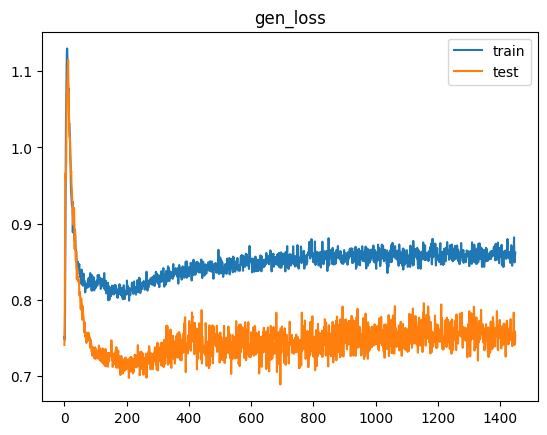

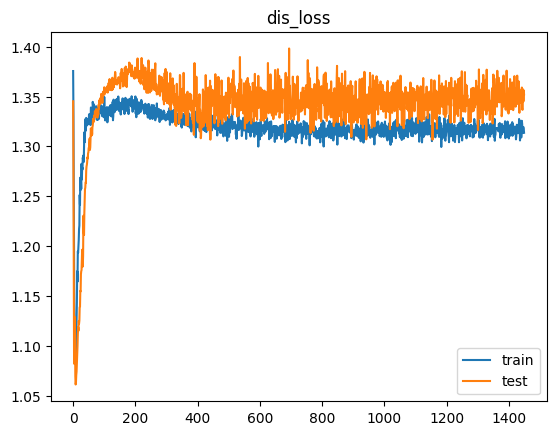

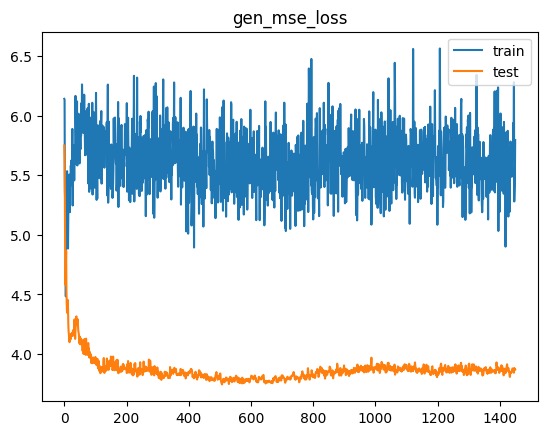

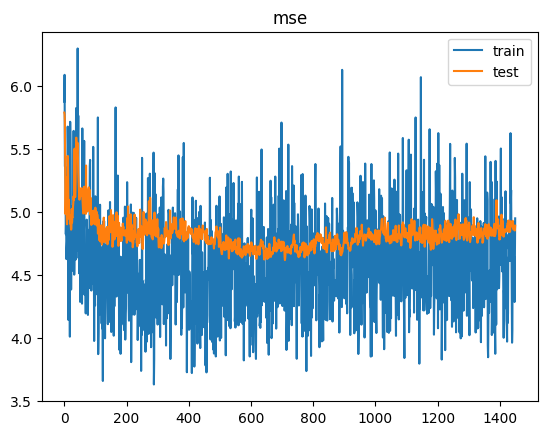

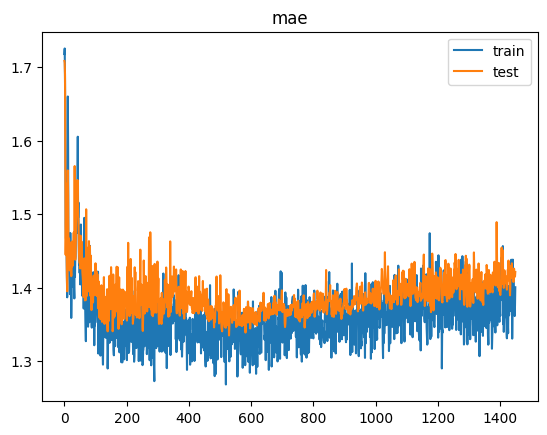

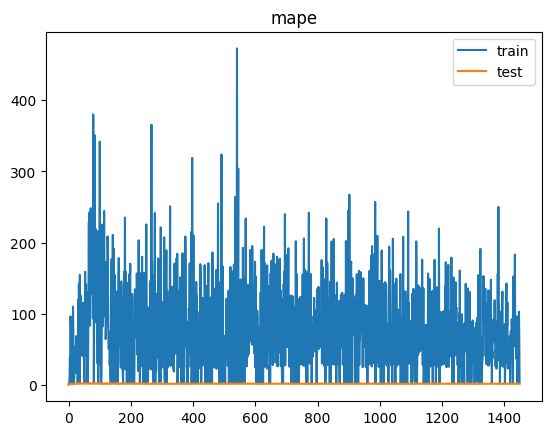

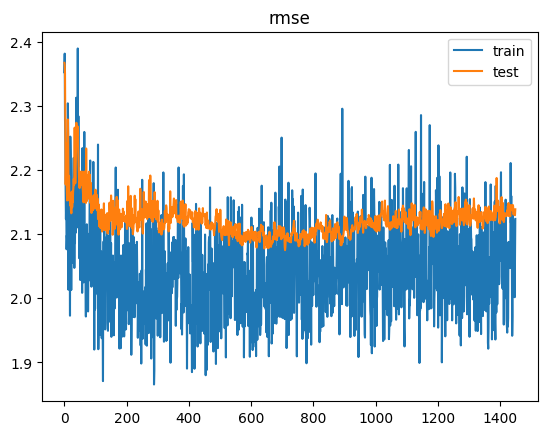

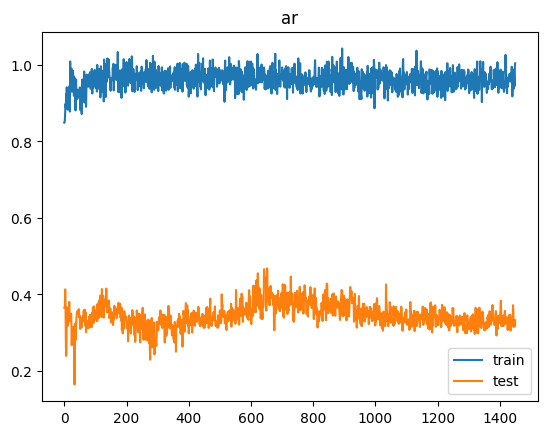

2/2 [==============================] - 1s 6ms/step


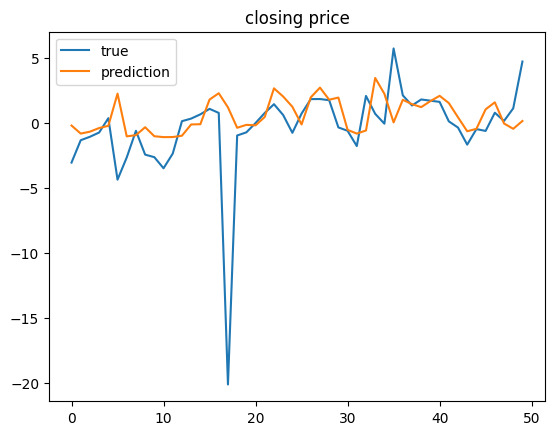

[MSE Baseline] train: 4.238850674083937  test: 4.695498675820508
Delta time with epochs = 1450: 0:30:11.091679
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 5, 20)       1440        ['input_7[0][0]']                
 l)                                                                                               
                                                                                                  
 concatenate_6 (Concatenate)    (None, 5, 27)        0           ['bidirectional_12[0][0]',       
                                                                  'input_7[0][0]

Time for epoch 46 is 1.2852418422698975 sec Generator Loss: 0.8039969205856323,  Discriminator_loss: 1.3487054109573364
Time for epoch 47 is 1.2467052936553955 sec Generator Loss: 0.7909516096115112,  Discriminator_loss: 1.3562828302383423
Time for epoch 48 is 1.2337965965270996 sec Generator Loss: 0.7977304458618164,  Discriminator_loss: 1.3476847410202026
Time for epoch 49 is 1.2383017539978027 sec Generator Loss: 0.7938355207443237,  Discriminator_loss: 1.3564846515655518
Time for epoch 50 is 1.2742013931274414 sec Generator Loss: 0.797542929649353,  Discriminator_loss: 1.3510667085647583
Time for epoch 51 is 1.2559208869934082 sec Generator Loss: 0.7972241044044495,  Discriminator_loss: 1.3511385917663574
Time for epoch 52 is 1.2250761985778809 sec Generator Loss: 0.798856258392334,  Discriminator_loss: 1.3513832092285156
Time for epoch 53 is 1.2415366172790527 sec Generator Loss: 0.7966351509094238,  Discriminator_loss: 1.3550571203231812
Time for epoch 54 is 1.2928833961486816 se

Time for epoch 115 is 1.262566328048706 sec Generator Loss: 0.7926223874092102,  Discriminator_loss: 1.3485469818115234
Time for epoch 116 is 1.2791824340820312 sec Generator Loss: 0.7857411503791809,  Discriminator_loss: 1.3520917892456055
Time for epoch 117 is 1.240877389907837 sec Generator Loss: 0.7916824817657471,  Discriminator_loss: 1.3476401567459106
Time for epoch 118 is 1.2645454406738281 sec Generator Loss: 0.7902751564979553,  Discriminator_loss: 1.357046365737915
Time for epoch 119 is 1.2838788032531738 sec Generator Loss: 0.7907142639160156,  Discriminator_loss: 1.3518434762954712
Time for epoch 120 is 1.2949028015136719 sec Generator Loss: 0.7895370125770569,  Discriminator_loss: 1.3528934717178345
Time for epoch 121 is 1.2721507549285889 sec Generator Loss: 0.7861398458480835,  Discriminator_loss: 1.3472844362258911
Time for epoch 122 is 1.2516837120056152 sec Generator Loss: 0.787296712398529,  Discriminator_loss: 1.348365068435669
Time for epoch 123 is 1.2511510848999

Time for epoch 184 is 1.3269233703613281 sec Generator Loss: 0.7961354851722717,  Discriminator_loss: 1.343171238899231
Time for epoch 185 is 1.330897569656372 sec Generator Loss: 0.7876758575439453,  Discriminator_loss: 1.3411186933517456
Time for epoch 186 is 1.344940423965454 sec Generator Loss: 0.7882078886032104,  Discriminator_loss: 1.3477797508239746
Time for epoch 187 is 1.313453197479248 sec Generator Loss: 0.7927156090736389,  Discriminator_loss: 1.3476241827011108
Time for epoch 188 is 1.3203480243682861 sec Generator Loss: 0.8029212355613708,  Discriminator_loss: 1.3453021049499512
Time for epoch 189 is 1.3504376411437988 sec Generator Loss: 0.793901801109314,  Discriminator_loss: 1.3459526300430298
Time for epoch 190 is 1.3391318321228027 sec Generator Loss: 0.7990763783454895,  Discriminator_loss: 1.3447376489639282
Time for epoch 191 is 1.312943935394287 sec Generator Loss: 0.8006494045257568,  Discriminator_loss: 1.3456015586853027
Time for epoch 192 is 1.33174538612365

Time for epoch 253 is 1.4137213230133057 sec Generator Loss: 0.8072260022163391,  Discriminator_loss: 1.335239052772522
Time for epoch 254 is 1.4177381992340088 sec Generator Loss: 0.8033157587051392,  Discriminator_loss: 1.3339312076568604
Time for epoch 255 is 1.3703229427337646 sec Generator Loss: 0.8083827495574951,  Discriminator_loss: 1.3331996202468872
Time for epoch 256 is 1.3465845584869385 sec Generator Loss: 0.8104653358459473,  Discriminator_loss: 1.3326935768127441
Time for epoch 257 is 1.3442294597625732 sec Generator Loss: 0.8126540780067444,  Discriminator_loss: 1.3281567096710205
Time for epoch 258 is 1.3393001556396484 sec Generator Loss: 0.8084327578544617,  Discriminator_loss: 1.3351616859436035
Time for epoch 259 is 1.5730400085449219 sec Generator Loss: 0.8085680603981018,  Discriminator_loss: 1.3337143659591675
Time for epoch 260 is 1.3361244201660156 sec Generator Loss: 0.8122630715370178,  Discriminator_loss: 1.3317668437957764
Time for epoch 261 is 1.318286895

Time for epoch 322 is 1.367408037185669 sec Generator Loss: 0.8292044997215271,  Discriminator_loss: 1.332345962524414
Time for epoch 323 is 1.3976943492889404 sec Generator Loss: 0.8200795650482178,  Discriminator_loss: 1.3260327577590942
Time for epoch 324 is 1.7219958305358887 sec Generator Loss: 0.8312567472457886,  Discriminator_loss: 1.321305751800537
Time for epoch 325 is 1.6068830490112305 sec Generator Loss: 0.818747341632843,  Discriminator_loss: 1.3303296566009521
Time for epoch 326 is 1.3932974338531494 sec Generator Loss: 0.8234152793884277,  Discriminator_loss: 1.324756145477295
Time for epoch 327 is 1.5398104190826416 sec Generator Loss: 0.8241065740585327,  Discriminator_loss: 1.3302029371261597
Time for epoch 328 is 1.36749267578125 sec Generator Loss: 0.8299175500869751,  Discriminator_loss: 1.3285479545593262
Time for epoch 329 is 1.322549819946289 sec Generator Loss: 0.8268092274665833,  Discriminator_loss: 1.3193219900131226
Time for epoch 330 is 1.3276488780975342

Time for epoch 391 is 1.480747938156128 sec Generator Loss: 0.8434516191482544,  Discriminator_loss: 1.314471960067749
Time for epoch 392 is 1.378934383392334 sec Generator Loss: 0.8378444314002991,  Discriminator_loss: 1.3144105672836304
Time for epoch 393 is 1.3506886959075928 sec Generator Loss: 0.8288829326629639,  Discriminator_loss: 1.3271621465682983
Time for epoch 394 is 1.3555216789245605 sec Generator Loss: 0.8216756582260132,  Discriminator_loss: 1.3348522186279297
Time for epoch 395 is 1.3578178882598877 sec Generator Loss: 0.8320163488388062,  Discriminator_loss: 1.3258260488510132
Time for epoch 396 is 1.3994100093841553 sec Generator Loss: 0.8352043032646179,  Discriminator_loss: 1.3257977962493896
Time for epoch 397 is 1.387497901916504 sec Generator Loss: 0.8310035467147827,  Discriminator_loss: 1.3246318101882935
Time for epoch 398 is 1.3480970859527588 sec Generator Loss: 0.8281797766685486,  Discriminator_loss: 1.3206640481948853
Time for epoch 399 is 1.380464076995

Time for epoch 459 is 1.3809332847595215 sec Generator Loss: 0.8365967273712158,  Discriminator_loss: 1.318056583404541
Time for epoch 460 is 1.3843638896942139 sec Generator Loss: 0.8460494875907898,  Discriminator_loss: 1.3180574178695679
Time for epoch 461 is 1.3598380088806152 sec Generator Loss: 0.8577812314033508,  Discriminator_loss: 1.308264970779419
Time for epoch 462 is 1.3321533203125 sec Generator Loss: 0.836297333240509,  Discriminator_loss: 1.3322861194610596
Time for epoch 463 is 1.374382495880127 sec Generator Loss: 0.8429840803146362,  Discriminator_loss: 1.3138811588287354
Time for epoch 464 is 1.479572057723999 sec Generator Loss: 0.8455042839050293,  Discriminator_loss: 1.3128169775009155
Time for epoch 465 is 1.412580966949463 sec Generator Loss: 0.8414639830589294,  Discriminator_loss: 1.3130970001220703
Time for epoch 466 is 1.4302470684051514 sec Generator Loss: 0.8433942198753357,  Discriminator_loss: 1.3123255968093872
Time for epoch 467 is 1.4010953903198242 

Time for epoch 528 is 1.4006469249725342 sec Generator Loss: 0.8446456789970398,  Discriminator_loss: 1.3095917701721191
Time for epoch 529 is 1.381730079650879 sec Generator Loss: 0.8613542914390564,  Discriminator_loss: 1.3108099699020386
Time for epoch 530 is 1.4403181076049805 sec Generator Loss: 0.8541205525398254,  Discriminator_loss: 1.3115127086639404
Time for epoch 531 is 1.3877496719360352 sec Generator Loss: 0.8471949100494385,  Discriminator_loss: 1.3168104887008667
Time for epoch 532 is 1.3717358112335205 sec Generator Loss: 0.8464921712875366,  Discriminator_loss: 1.3155343532562256
Time for epoch 533 is 1.4562997817993164 sec Generator Loss: 0.85174959897995,  Discriminator_loss: 1.3134087324142456
Time for epoch 534 is 1.4068021774291992 sec Generator Loss: 0.8517811894416809,  Discriminator_loss: 1.3226040601730347
Time for epoch 535 is 1.3911995887756348 sec Generator Loss: 0.8497455716133118,  Discriminator_loss: 1.3133339881896973
Time for epoch 536 is 1.40294337272

Time for epoch 597 is 1.4588210582733154 sec Generator Loss: 0.8557109832763672,  Discriminator_loss: 1.314921259880066
Time for epoch 598 is 1.4107022285461426 sec Generator Loss: 0.854113757610321,  Discriminator_loss: 1.3093442916870117
Time for epoch 599 is 1.4606983661651611 sec Generator Loss: 0.8428617715835571,  Discriminator_loss: 1.3247966766357422
Time for epoch 600 is 1.6126813888549805 sec Generator Loss: 0.850436806678772,  Discriminator_loss: 1.3154340982437134
Time for epoch 601 is 1.4223432540893555 sec Generator Loss: 0.8500828146934509,  Discriminator_loss: 1.3136357069015503
Time for epoch 602 is 1.4795637130737305 sec Generator Loss: 0.8461509943008423,  Discriminator_loss: 1.3186304569244385
Time for epoch 603 is 1.4870145320892334 sec Generator Loss: 0.8476345539093018,  Discriminator_loss: 1.3119479417800903
Time for epoch 604 is 1.511540412902832 sec Generator Loss: 0.8512063026428223,  Discriminator_loss: 1.3114608526229858
Time for epoch 605 is 1.497596025466

Time for epoch 666 is 1.5794169902801514 sec Generator Loss: 0.8618860244750977,  Discriminator_loss: 1.3046972751617432
Time for epoch 667 is 1.5606276988983154 sec Generator Loss: 0.8477033972740173,  Discriminator_loss: 1.3096015453338623
Time for epoch 668 is 1.4514102935791016 sec Generator Loss: 0.8625383973121643,  Discriminator_loss: 1.3092973232269287
Time for epoch 669 is 1.4324781894683838 sec Generator Loss: 0.8559126257896423,  Discriminator_loss: 1.3052055835723877
Time for epoch 670 is 1.3453919887542725 sec Generator Loss: 0.8481245040893555,  Discriminator_loss: 1.3128135204315186
Time for epoch 671 is 1.4363148212432861 sec Generator Loss: 0.8690820932388306,  Discriminator_loss: 1.309902310371399
Time for epoch 672 is 1.4292044639587402 sec Generator Loss: 0.8551896214485168,  Discriminator_loss: 1.3115192651748657
Time for epoch 673 is 1.3430426120758057 sec Generator Loss: 0.8576488494873047,  Discriminator_loss: 1.3049991130828857
Time for epoch 674 is 1.352922439

Time for epoch 735 is 1.651247501373291 sec Generator Loss: 0.8637334108352661,  Discriminator_loss: 1.3081201314926147
Time for epoch 736 is 1.573312520980835 sec Generator Loss: 0.8691458106040955,  Discriminator_loss: 1.3009907007217407
Time for epoch 737 is 1.4899463653564453 sec Generator Loss: 0.8505244851112366,  Discriminator_loss: 1.3060600757598877
Time for epoch 738 is 1.444777250289917 sec Generator Loss: 0.8602896928787231,  Discriminator_loss: 1.312208890914917
Time for epoch 739 is 1.443047285079956 sec Generator Loss: 0.8629611134529114,  Discriminator_loss: 1.309648036956787
Time for epoch 740 is 1.6613266468048096 sec Generator Loss: 0.8569447994232178,  Discriminator_loss: 1.3084574937820435
Time for epoch 741 is 1.647637128829956 sec Generator Loss: 0.858307957649231,  Discriminator_loss: 1.3159080743789673
Time for epoch 742 is 1.5664138793945312 sec Generator Loss: 0.8667289614677429,  Discriminator_loss: 1.3017970323562622
Time for epoch 743 is 1.5171842575073242

Time for epoch 804 is 1.4473316669464111 sec Generator Loss: 0.8562272787094116,  Discriminator_loss: 1.3112155199050903
Time for epoch 805 is 1.4699819087982178 sec Generator Loss: 0.8476547598838806,  Discriminator_loss: 1.317963719367981
Time for epoch 806 is 1.5041615962982178 sec Generator Loss: 0.8607039451599121,  Discriminator_loss: 1.3044075965881348
Time for epoch 807 is 1.559272050857544 sec Generator Loss: 0.8697441816329956,  Discriminator_loss: 1.2963840961456299
Time for epoch 808 is 1.4518988132476807 sec Generator Loss: 0.8517003655433655,  Discriminator_loss: 1.3173226118087769
Time for epoch 809 is 1.524343490600586 sec Generator Loss: 0.8535404205322266,  Discriminator_loss: 1.3050390481948853
Time for epoch 810 is 1.4692487716674805 sec Generator Loss: 0.8675016760826111,  Discriminator_loss: 1.2982202768325806
Time for epoch 811 is 1.5090303421020508 sec Generator Loss: 0.8706896305084229,  Discriminator_loss: 1.303736686706543
Time for epoch 812 is 1.494942188262

Time for epoch 873 is 1.4994432926177979 sec Generator Loss: 0.8666770458221436,  Discriminator_loss: 1.30574369430542
Time for epoch 874 is 1.619502305984497 sec Generator Loss: 0.87821364402771,  Discriminator_loss: 1.3022172451019287
Time for epoch 875 is 1.6523687839508057 sec Generator Loss: 0.8760733604431152,  Discriminator_loss: 1.292557716369629
Time for epoch 876 is 1.6431357860565186 sec Generator Loss: 0.8595887422561646,  Discriminator_loss: 1.3133478164672852
Time for epoch 877 is 1.7443315982818604 sec Generator Loss: 0.8696528673171997,  Discriminator_loss: 1.3089361190795898
Time for epoch 878 is 1.6309788227081299 sec Generator Loss: 0.8672955632209778,  Discriminator_loss: 1.3050888776779175
Time for epoch 879 is 1.522611379623413 sec Generator Loss: 0.8605665564537048,  Discriminator_loss: 1.3162462711334229
Time for epoch 880 is 1.5340042114257812 sec Generator Loss: 0.8586918115615845,  Discriminator_loss: 1.3158432245254517
Time for epoch 881 is 1.586223125457763

Time for epoch 942 is 1.6173853874206543 sec Generator Loss: 0.8610976338386536,  Discriminator_loss: 1.306473731994629
Time for epoch 943 is 1.582301378250122 sec Generator Loss: 0.8601220846176147,  Discriminator_loss: 1.3096678256988525
Time for epoch 944 is 1.8605120182037354 sec Generator Loss: 0.855097770690918,  Discriminator_loss: 1.3171216249465942
Time for epoch 945 is 1.8501965999603271 sec Generator Loss: 0.8597710728645325,  Discriminator_loss: 1.311009407043457
Time for epoch 946 is 1.699479579925537 sec Generator Loss: 0.8741707801818848,  Discriminator_loss: 1.2946293354034424
Time for epoch 947 is 1.528754472732544 sec Generator Loss: 0.8713743686676025,  Discriminator_loss: 1.306277871131897
Time for epoch 948 is 1.6269376277923584 sec Generator Loss: 0.8728755116462708,  Discriminator_loss: 1.3016520738601685
Time for epoch 949 is 1.8934128284454346 sec Generator Loss: 0.8613426685333252,  Discriminator_loss: 1.3055188655853271
Time for epoch 950 is 1.785233259201049

Time for epoch 1010 is 1.5590853691101074 sec Generator Loss: 0.8655206561088562,  Discriminator_loss: 1.3033376932144165
Time for epoch 1011 is 1.575666904449463 sec Generator Loss: 0.867029070854187,  Discriminator_loss: 1.3049647808074951
Time for epoch 1012 is 1.5629026889801025 sec Generator Loss: 0.8546763062477112,  Discriminator_loss: 1.3238483667373657
Time for epoch 1013 is 1.5855848789215088 sec Generator Loss: 0.8588044047355652,  Discriminator_loss: 1.3109772205352783
Time for epoch 1014 is 1.5273678302764893 sec Generator Loss: 0.8528805375099182,  Discriminator_loss: 1.309493899345398
Time for epoch 1015 is 1.592621088027954 sec Generator Loss: 0.8690922856330872,  Discriminator_loss: 1.3113861083984375
Time for epoch 1016 is 1.54768967628479 sec Generator Loss: 0.8757829666137695,  Discriminator_loss: 1.3044116497039795
Time for epoch 1017 is 1.5633392333984375 sec Generator Loss: 0.8560887575149536,  Discriminator_loss: 1.313453197479248
Time for epoch 1018 is 1.576966

Time for epoch 1078 is 1.6822545528411865 sec Generator Loss: 0.8660266399383545,  Discriminator_loss: 1.3063610792160034
Time for epoch 1079 is 1.6489989757537842 sec Generator Loss: 0.8618572354316711,  Discriminator_loss: 1.3098995685577393
Time for epoch 1080 is 1.6678094863891602 sec Generator Loss: 0.8669540882110596,  Discriminator_loss: 1.3037306070327759
Time for epoch 1081 is 1.6594140529632568 sec Generator Loss: 0.8527346253395081,  Discriminator_loss: 1.3171641826629639
Time for epoch 1082 is 1.632699966430664 sec Generator Loss: 0.8610087633132935,  Discriminator_loss: 1.3042713403701782
Time for epoch 1083 is 1.7061126232147217 sec Generator Loss: 0.8608943223953247,  Discriminator_loss: 1.314609169960022
Time for epoch 1084 is 1.6553237438201904 sec Generator Loss: 0.8596858382225037,  Discriminator_loss: 1.3162758350372314
Time for epoch 1085 is 1.6537342071533203 sec Generator Loss: 0.8646571040153503,  Discriminator_loss: 1.311909556388855
Time for epoch 1086 is 1.85

Time for epoch 1146 is 2.2929229736328125 sec Generator Loss: 0.8672891855239868,  Discriminator_loss: 1.3084428310394287
Time for epoch 1147 is 1.9213716983795166 sec Generator Loss: 0.8678478598594666,  Discriminator_loss: 1.3134723901748657
Time for epoch 1148 is 1.800814151763916 sec Generator Loss: 0.8573412299156189,  Discriminator_loss: 1.3141878843307495
Time for epoch 1149 is 1.8451499938964844 sec Generator Loss: 0.8610098361968994,  Discriminator_loss: 1.318503737449646
Time for epoch 1150 is 2.3016796112060547 sec Generator Loss: 0.858283519744873,  Discriminator_loss: 1.3093088865280151
Time for epoch 1151 is 2.0116875171661377 sec Generator Loss: 0.854920506477356,  Discriminator_loss: 1.3097758293151855
Time for epoch 1152 is 1.8953351974487305 sec Generator Loss: 0.8495685458183289,  Discriminator_loss: 1.3202890157699585
Time for epoch 1153 is 1.8212509155273438 sec Generator Loss: 0.866249680519104,  Discriminator_loss: 1.305955410003662
Time for epoch 1154 is 1.86164

Time for epoch 1214 is 1.8177635669708252 sec Generator Loss: 0.8663246631622314,  Discriminator_loss: 1.307112216949463
Time for epoch 1215 is 1.8294439315795898 sec Generator Loss: 0.867518424987793,  Discriminator_loss: 1.3044753074645996
Time for epoch 1216 is 1.9194176197052002 sec Generator Loss: 0.8688449859619141,  Discriminator_loss: 1.2990269660949707
Time for epoch 1217 is 1.870112657546997 sec Generator Loss: 0.870929479598999,  Discriminator_loss: 1.311464786529541
Time for epoch 1218 is 1.8435235023498535 sec Generator Loss: 0.8743135333061218,  Discriminator_loss: 1.3081477880477905
Time for epoch 1219 is 1.8856775760650635 sec Generator Loss: 0.8657128810882568,  Discriminator_loss: 1.3133589029312134
Time for epoch 1220 is 1.871985673904419 sec Generator Loss: 0.8720778226852417,  Discriminator_loss: 1.3034662008285522
Time for epoch 1221 is 1.9682769775390625 sec Generator Loss: 0.8727043271064758,  Discriminator_loss: 1.3023159503936768
Time for epoch 1222 is 1.95100

Time for epoch 1282 is 1.902505874633789 sec Generator Loss: 0.8567498922348022,  Discriminator_loss: 1.309855341911316
Time for epoch 1283 is 1.8986127376556396 sec Generator Loss: 0.8703193068504333,  Discriminator_loss: 1.3130017518997192
Time for epoch 1284 is 1.8477680683135986 sec Generator Loss: 0.8725289106369019,  Discriminator_loss: 1.2957907915115356
Time for epoch 1285 is 1.9170770645141602 sec Generator Loss: 0.867346465587616,  Discriminator_loss: 1.3100793361663818
Time for epoch 1286 is 1.8728654384613037 sec Generator Loss: 0.8665308356285095,  Discriminator_loss: 1.3016831874847412
Time for epoch 1287 is 1.9543380737304688 sec Generator Loss: 0.8607910871505737,  Discriminator_loss: 1.314466953277588
Time for epoch 1288 is 2.2210967540740967 sec Generator Loss: 0.870715320110321,  Discriminator_loss: 1.3029743432998657
Time for epoch 1289 is 1.9680185317993164 sec Generator Loss: 0.8706862330436707,  Discriminator_loss: 1.305249810218811
Time for epoch 1290 is 1.89810

Time for epoch 1350 is 1.9307942390441895 sec Generator Loss: 0.8692748546600342,  Discriminator_loss: 1.30572509765625
Time for epoch 1351 is 2.0334770679473877 sec Generator Loss: 0.8621091842651367,  Discriminator_loss: 1.3207859992980957
Time for epoch 1352 is 1.9518282413482666 sec Generator Loss: 0.8539118766784668,  Discriminator_loss: 1.3130501508712769
Time for epoch 1353 is 2.0322723388671875 sec Generator Loss: 0.8656811714172363,  Discriminator_loss: 1.306929588317871
Time for epoch 1354 is 2.0044407844543457 sec Generator Loss: 0.8755025863647461,  Discriminator_loss: 1.3021584749221802
Time for epoch 1355 is 2.0249898433685303 sec Generator Loss: 0.8466407060623169,  Discriminator_loss: 1.3201674222946167
Time for epoch 1356 is 2.0318238735198975 sec Generator Loss: 0.860662579536438,  Discriminator_loss: 1.3196861743927002
Time for epoch 1357 is 1.9695141315460205 sec Generator Loss: 0.8662868738174438,  Discriminator_loss: 1.312253475189209
Time for epoch 1358 is 1.8968

Time for epoch 1418 is 1.9986939430236816 sec Generator Loss: 0.8744120597839355,  Discriminator_loss: 1.3023492097854614
Time for epoch 1419 is 1.9059977531433105 sec Generator Loss: 0.8588529825210571,  Discriminator_loss: 1.3217833042144775
Time for epoch 1420 is 1.904130220413208 sec Generator Loss: 0.8582272529602051,  Discriminator_loss: 1.304483413696289
Time for epoch 1421 is 1.9702143669128418 sec Generator Loss: 0.8536967039108276,  Discriminator_loss: 1.3121418952941895
Time for epoch 1422 is 1.9633100032806396 sec Generator Loss: 0.8620073199272156,  Discriminator_loss: 1.3049383163452148
Time for epoch 1423 is 1.9745523929595947 sec Generator Loss: 0.8629944920539856,  Discriminator_loss: 1.3165202140808105
Time for epoch 1424 is 1.9249930381774902 sec Generator Loss: 0.8708071112632751,  Discriminator_loss: 1.3136249780654907
Time for epoch 1425 is 1.9400174617767334 sec Generator Loss: 0.8585061430931091,  Discriminator_loss: 1.313161015510559
Time for epoch 1426 is 2.00

Time for epoch 1486 is 1.937272548675537 sec Generator Loss: 0.8791719079017639,  Discriminator_loss: 1.3022516965866089
Time for epoch 1487 is 2.0037841796875 sec Generator Loss: 0.8806505799293518,  Discriminator_loss: 1.298979640007019
Time for epoch 1488 is 2.55301570892334 sec Generator Loss: 0.8550913333892822,  Discriminator_loss: 1.3183866739273071
Time for epoch 1489 is 2.294534921646118 sec Generator Loss: 0.8709290623664856,  Discriminator_loss: 1.2980655431747437
Time for epoch 1490 is 2.1283211708068848 sec Generator Loss: 0.8602243065834045,  Discriminator_loss: 1.3127081394195557
Time for epoch 1491 is 2.2218689918518066 sec Generator Loss: 0.8597630262374878,  Discriminator_loss: 1.3132994174957275
Time for epoch 1492 is 2.249033212661743 sec Generator Loss: 0.8736419081687927,  Discriminator_loss: 1.30106520652771
Time for epoch 1493 is 2.118027687072754 sec Generator Loss: 0.8515589833259583,  Discriminator_loss: 1.3148529529571533
Time for epoch 1494 is 2.42101716995

Time for epoch 1554 is 2.0323550701141357 sec Generator Loss: 0.8732452988624573,  Discriminator_loss: 1.2986646890640259
Time for epoch 1555 is 2.063000202178955 sec Generator Loss: 0.8776346445083618,  Discriminator_loss: 1.3085639476776123
Time for epoch 1556 is 2.0403008460998535 sec Generator Loss: 0.8708860278129578,  Discriminator_loss: 1.3156238794326782
Time for epoch 1557 is 1.9708638191223145 sec Generator Loss: 0.8749443888664246,  Discriminator_loss: 1.3044215440750122
Time for epoch 1558 is 2.013381004333496 sec Generator Loss: 0.8616560101509094,  Discriminator_loss: 1.3054174184799194
Time for epoch 1559 is 2.0042552947998047 sec Generator Loss: 0.8601624965667725,  Discriminator_loss: 1.3194458484649658
Time for epoch 1560 is 2.028136968612671 sec Generator Loss: 0.8735280632972717,  Discriminator_loss: 1.3017150163650513
Time for epoch 1561 is 2.0535459518432617 sec Generator Loss: 0.876175582408905,  Discriminator_loss: 1.302236557006836
Time for epoch 1562 is 1.9867

Time for epoch 1622 is 2.2003657817840576 sec Generator Loss: 0.8723758459091187,  Discriminator_loss: 1.310549259185791
Time for epoch 1623 is 2.0761468410491943 sec Generator Loss: 0.8748112320899963,  Discriminator_loss: 1.3070995807647705
Time for epoch 1624 is 2.090606212615967 sec Generator Loss: 0.8585660457611084,  Discriminator_loss: 1.3104028701782227
Time for epoch 1625 is 2.0870614051818848 sec Generator Loss: 0.8758750557899475,  Discriminator_loss: 1.2941614389419556
Time for epoch 1626 is 2.011681079864502 sec Generator Loss: 0.8706135749816895,  Discriminator_loss: 1.308152198791504
Time for epoch 1627 is 2.069406032562256 sec Generator Loss: 0.8707900047302246,  Discriminator_loss: 1.3082945346832275
Time for epoch 1628 is 2.1358954906463623 sec Generator Loss: 0.8609948754310608,  Discriminator_loss: 1.3090101480484009
Time for epoch 1629 is 2.158621072769165 sec Generator Loss: 0.8822272419929504,  Discriminator_loss: 1.3072693347930908
Time for epoch 1630 is 2.17716

Time for epoch 1690 is 2.2323966026306152 sec Generator Loss: 0.872481644153595,  Discriminator_loss: 1.3127624988555908
Time for epoch 1691 is 2.1007840633392334 sec Generator Loss: 0.870332658290863,  Discriminator_loss: 1.3075140714645386
Time for epoch 1692 is 2.0425634384155273 sec Generator Loss: 0.8684858083724976,  Discriminator_loss: 1.3080943822860718
Time for epoch 1693 is 2.1160800457000732 sec Generator Loss: 0.8633163571357727,  Discriminator_loss: 1.3152614831924438
Time for epoch 1694 is 2.2400617599487305 sec Generator Loss: 0.8628948926925659,  Discriminator_loss: 1.316561222076416
Time for epoch 1695 is 2.09975528717041 sec Generator Loss: 0.8679996132850647,  Discriminator_loss: 1.3052911758422852
Time for epoch 1696 is 2.2399520874023438 sec Generator Loss: 0.8740337491035461,  Discriminator_loss: 1.306864619255066
Time for epoch 1697 is 2.0603432655334473 sec Generator Loss: 0.873908519744873,  Discriminator_loss: 1.3015484809875488
Time for epoch 1698 is 2.100500

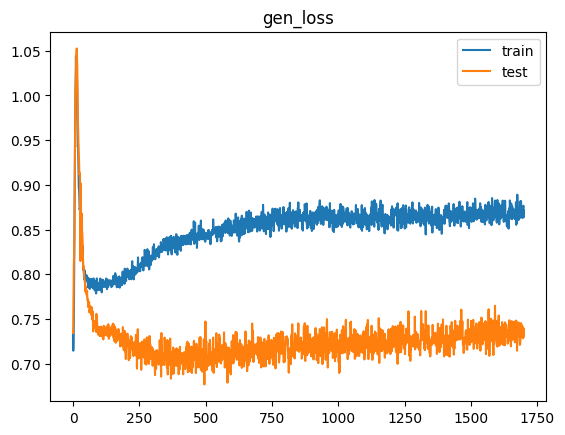

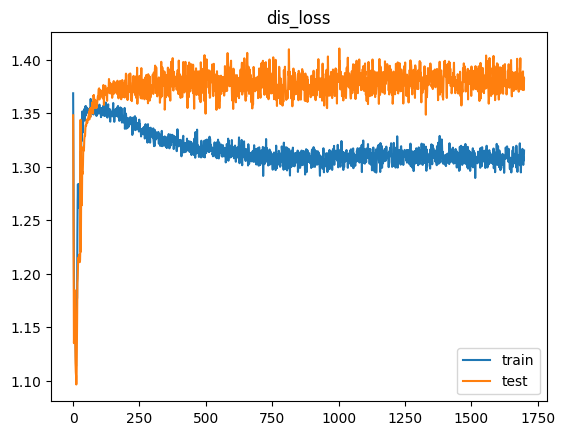

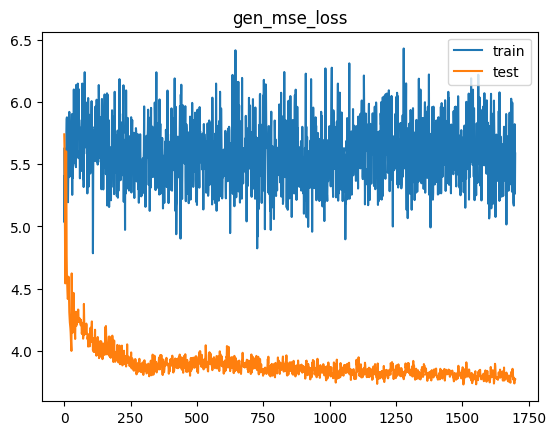

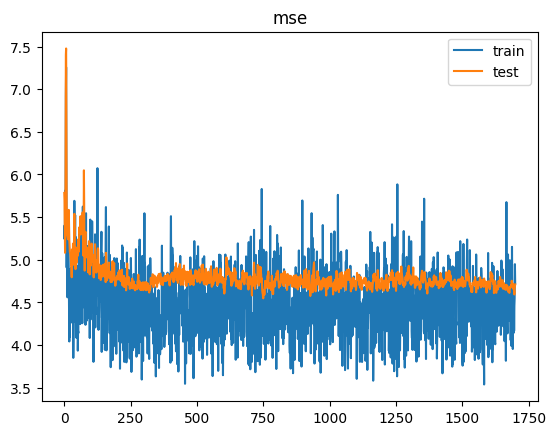

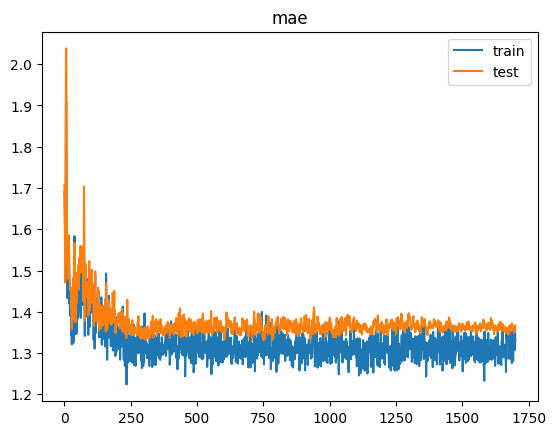

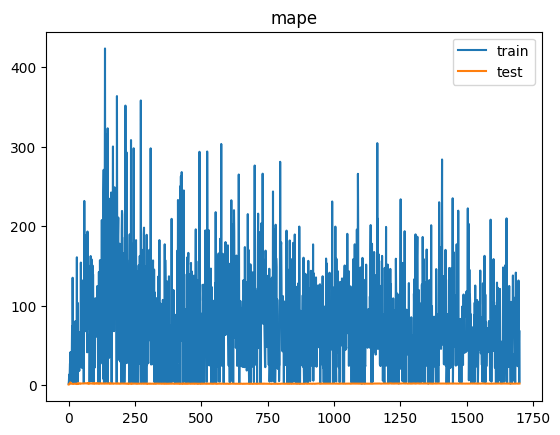

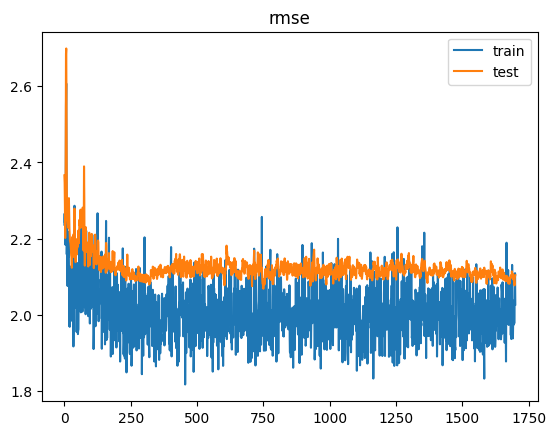

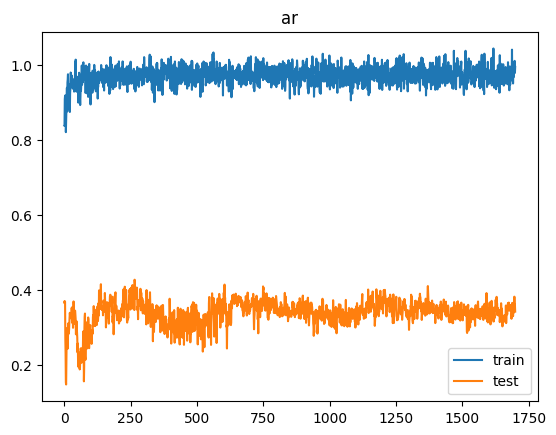

2/2 [==============================] - 1s 12ms/step


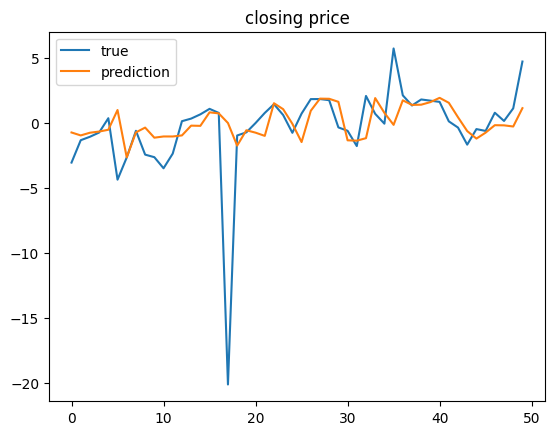

[MSE Baseline] train: 4.3302968603846415  test: 4.695498675820508
Delta time with epochs = 1700: 0:47:12.841321
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_14 (Bidirectiona  (None, 5, 20)       1440        ['input_8[0][0]']                
 l)                                                                                               
                                                                                                  
 concatenate_7 (Concatenate)    (None, 5, 27)        0           ['bidirectional_14[0][0]',       
                                                                  'input_8[0][0

Time for epoch 46 is 1.9020380973815918 sec Generator Loss: 0.8049802780151367,  Discriminator_loss: 1.3457353115081787
Time for epoch 47 is 1.8804841041564941 sec Generator Loss: 0.8017047643661499,  Discriminator_loss: 1.3482108116149902
Time for epoch 48 is 1.8509206771850586 sec Generator Loss: 0.8066907525062561,  Discriminator_loss: 1.3455654382705688
Time for epoch 49 is 1.8987452983856201 sec Generator Loss: 0.7997783422470093,  Discriminator_loss: 1.347204566001892
Time for epoch 50 is 1.908024787902832 sec Generator Loss: 0.8029619455337524,  Discriminator_loss: 1.3449501991271973
Time for epoch 51 is 1.9466814994812012 sec Generator Loss: 0.8041962385177612,  Discriminator_loss: 1.3436789512634277
Time for epoch 52 is 1.8777663707733154 sec Generator Loss: 0.796880841255188,  Discriminator_loss: 1.3348287343978882
Time for epoch 53 is 1.9126572608947754 sec Generator Loss: 0.8126205801963806,  Discriminator_loss: 1.3374989032745361
Time for epoch 54 is 1.8811562061309814 sec

Time for epoch 115 is 1.599724292755127 sec Generator Loss: 0.8031970858573914,  Discriminator_loss: 1.3438109159469604
Time for epoch 116 is 1.5906126499176025 sec Generator Loss: 0.8056192398071289,  Discriminator_loss: 1.3395850658416748
Time for epoch 117 is 1.608440637588501 sec Generator Loss: 0.7962711453437805,  Discriminator_loss: 1.3422439098358154
Time for epoch 118 is 1.5774016380310059 sec Generator Loss: 0.8009745478630066,  Discriminator_loss: 1.342655897140503
Time for epoch 119 is 1.5890405178070068 sec Generator Loss: 0.8032216429710388,  Discriminator_loss: 1.3382066488265991
Time for epoch 120 is 1.6148889064788818 sec Generator Loss: 0.8040941953659058,  Discriminator_loss: 1.3397653102874756
Time for epoch 121 is 1.6198475360870361 sec Generator Loss: 0.7994794845581055,  Discriminator_loss: 1.336807131767273
Time for epoch 122 is 1.6315052509307861 sec Generator Loss: 0.8013321757316589,  Discriminator_loss: 1.3418267965316772
Time for epoch 123 is 1.749689817428

Time for epoch 184 is 1.578465461730957 sec Generator Loss: 0.8073861002922058,  Discriminator_loss: 1.3361068964004517
Time for epoch 185 is 1.5923099517822266 sec Generator Loss: 0.7993188500404358,  Discriminator_loss: 1.3444054126739502
Time for epoch 186 is 1.6502127647399902 sec Generator Loss: 0.7995339632034302,  Discriminator_loss: 1.3470206260681152
Time for epoch 187 is 1.6480739116668701 sec Generator Loss: 0.7996119856834412,  Discriminator_loss: 1.3465439081192017
Time for epoch 188 is 1.6028923988342285 sec Generator Loss: 0.799092173576355,  Discriminator_loss: 1.342821478843689
Time for epoch 189 is 1.6158828735351562 sec Generator Loss: 0.8048186898231506,  Discriminator_loss: 1.3391104936599731
Time for epoch 190 is 1.5843002796173096 sec Generator Loss: 0.7997307777404785,  Discriminator_loss: 1.3418896198272705
Time for epoch 191 is 1.6034886837005615 sec Generator Loss: 0.8046831488609314,  Discriminator_loss: 1.3385041952133179
Time for epoch 192 is 1.58510065078

Time for epoch 252 is 1.650604248046875 sec Generator Loss: 0.8093322515487671,  Discriminator_loss: 1.3400218486785889
Time for epoch 253 is 1.681396722793579 sec Generator Loss: 0.8133319616317749,  Discriminator_loss: 1.3324079513549805
Time for epoch 254 is 1.7051572799682617 sec Generator Loss: 0.8060948848724365,  Discriminator_loss: 1.3381812572479248
Time for epoch 255 is 1.638063907623291 sec Generator Loss: 0.8133760094642639,  Discriminator_loss: 1.3307629823684692
Time for epoch 256 is 1.613204002380371 sec Generator Loss: 0.8178596496582031,  Discriminator_loss: 1.3337595462799072
Time for epoch 257 is 1.6077532768249512 sec Generator Loss: 0.819291353225708,  Discriminator_loss: 1.3321505784988403
Time for epoch 258 is 1.629035472869873 sec Generator Loss: 0.8099775314331055,  Discriminator_loss: 1.3344697952270508
Time for epoch 259 is 1.7022526264190674 sec Generator Loss: 0.8201017379760742,  Discriminator_loss: 1.335318684577942
Time for epoch 260 is 1.670029640197754

Time for epoch 321 is 1.6890418529510498 sec Generator Loss: 0.8271869421005249,  Discriminator_loss: 1.3220956325531006
Time for epoch 322 is 1.708991527557373 sec Generator Loss: 0.8154146075248718,  Discriminator_loss: 1.3357148170471191
Time for epoch 323 is 1.7475979328155518 sec Generator Loss: 0.835395097732544,  Discriminator_loss: 1.3140639066696167
Time for epoch 324 is 1.8384156227111816 sec Generator Loss: 0.8296105265617371,  Discriminator_loss: 1.326596975326538
Time for epoch 325 is 1.7410025596618652 sec Generator Loss: 0.8284772038459778,  Discriminator_loss: 1.3239214420318604
Time for epoch 326 is 1.7258286476135254 sec Generator Loss: 0.8365756273269653,  Discriminator_loss: 1.3253428936004639
Time for epoch 327 is 1.6990153789520264 sec Generator Loss: 0.8238552808761597,  Discriminator_loss: 1.3213526010513306
Time for epoch 328 is 1.6602823734283447 sec Generator Loss: 0.836866557598114,  Discriminator_loss: 1.314475655555725
Time for epoch 329 is 1.8153855800628

Time for epoch 390 is 1.8846123218536377 sec Generator Loss: 0.8337458968162537,  Discriminator_loss: 1.3254876136779785
Time for epoch 391 is 1.7129230499267578 sec Generator Loss: 0.8361981511116028,  Discriminator_loss: 1.3093841075897217
Time for epoch 392 is 1.8435578346252441 sec Generator Loss: 0.8328060507774353,  Discriminator_loss: 1.3207095861434937
Time for epoch 393 is 1.7770161628723145 sec Generator Loss: 0.8368258476257324,  Discriminator_loss: 1.3165112733840942
Time for epoch 394 is 1.9882314205169678 sec Generator Loss: 0.8297554850578308,  Discriminator_loss: 1.3196845054626465
Time for epoch 395 is 1.9574737548828125 sec Generator Loss: 0.8293138146400452,  Discriminator_loss: 1.3204007148742676
Time for epoch 396 is 1.8113820552825928 sec Generator Loss: 0.8442533016204834,  Discriminator_loss: 1.3145067691802979
Time for epoch 397 is 1.7892508506774902 sec Generator Loss: 0.842644453048706,  Discriminator_loss: 1.309489369392395
Time for epoch 398 is 1.8507757186

Time for epoch 458 is 1.7242457866668701 sec Generator Loss: 0.8421021699905396,  Discriminator_loss: 1.3161897659301758
Time for epoch 459 is 1.742973804473877 sec Generator Loss: 0.8441324234008789,  Discriminator_loss: 1.316068410873413
Time for epoch 460 is 1.7805171012878418 sec Generator Loss: 0.8360728025436401,  Discriminator_loss: 1.3208063840866089
Time for epoch 461 is 1.7726914882659912 sec Generator Loss: 0.8477530479431152,  Discriminator_loss: 1.311718463897705
Time for epoch 462 is 1.7444484233856201 sec Generator Loss: 0.8314315676689148,  Discriminator_loss: 1.3216733932495117
Time for epoch 463 is 1.7571022510528564 sec Generator Loss: 0.8401103615760803,  Discriminator_loss: 1.3265419006347656
Time for epoch 464 is 1.7311007976531982 sec Generator Loss: 0.8330467939376831,  Discriminator_loss: 1.3188799619674683
Time for epoch 465 is 1.8121402263641357 sec Generator Loss: 0.8432543873786926,  Discriminator_loss: 1.3126972913742065
Time for epoch 466 is 1.97410011291

Time for epoch 527 is 1.8167524337768555 sec Generator Loss: 0.8438964486122131,  Discriminator_loss: 1.3132328987121582
Time for epoch 528 is 1.8016750812530518 sec Generator Loss: 0.8529071807861328,  Discriminator_loss: 1.3130927085876465
Time for epoch 529 is 1.8427751064300537 sec Generator Loss: 0.8515865206718445,  Discriminator_loss: 1.3074666261672974
Time for epoch 530 is 1.8353314399719238 sec Generator Loss: 0.8416988253593445,  Discriminator_loss: 1.3205862045288086
Time for epoch 531 is 1.8881080150604248 sec Generator Loss: 0.8489400744438171,  Discriminator_loss: 1.3141016960144043
Time for epoch 532 is 1.8031365871429443 sec Generator Loss: 0.8512287139892578,  Discriminator_loss: 1.309889316558838
Time for epoch 533 is 1.86635422706604 sec Generator Loss: 0.8394458293914795,  Discriminator_loss: 1.3200916051864624
Time for epoch 534 is 1.804553508758545 sec Generator Loss: 0.8514922261238098,  Discriminator_loss: 1.3156596422195435
Time for epoch 535 is 1.785456895828

Time for epoch 596 is 1.8000974655151367 sec Generator Loss: 0.8488299250602722,  Discriminator_loss: 1.3152846097946167
Time for epoch 597 is 1.834505319595337 sec Generator Loss: 0.8449441194534302,  Discriminator_loss: 1.3189924955368042
Time for epoch 598 is 1.9421882629394531 sec Generator Loss: 0.8400283455848694,  Discriminator_loss: 1.3174172639846802
Time for epoch 599 is 1.976586103439331 sec Generator Loss: 0.8583810925483704,  Discriminator_loss: 1.3088833093643188
Time for epoch 600 is 1.8648416996002197 sec Generator Loss: 0.8516576886177063,  Discriminator_loss: 1.3177692890167236
Time for epoch 601 is 1.8668010234832764 sec Generator Loss: 0.8507458567619324,  Discriminator_loss: 1.3173186779022217
Time for epoch 602 is 1.8344080448150635 sec Generator Loss: 0.8492172956466675,  Discriminator_loss: 1.3144384622573853
Time for epoch 603 is 1.8368992805480957 sec Generator Loss: 0.8520050644874573,  Discriminator_loss: 1.3145020008087158
Time for epoch 604 is 1.8895726203

Time for epoch 665 is 1.856459140777588 sec Generator Loss: 0.8424477577209473,  Discriminator_loss: 1.3230587244033813
Time for epoch 666 is 1.909067153930664 sec Generator Loss: 0.8469802737236023,  Discriminator_loss: 1.3192341327667236
Time for epoch 667 is 1.8905177116394043 sec Generator Loss: 0.8517820835113525,  Discriminator_loss: 1.3160868883132935
Time for epoch 668 is 1.8234171867370605 sec Generator Loss: 0.8471148610115051,  Discriminator_loss: 1.3157204389572144
Time for epoch 669 is 1.9032096862792969 sec Generator Loss: 0.846129834651947,  Discriminator_loss: 1.3197427988052368
Time for epoch 670 is 1.8214459419250488 sec Generator Loss: 0.8506142497062683,  Discriminator_loss: 1.3167307376861572
Time for epoch 671 is 1.844775676727295 sec Generator Loss: 0.8386040925979614,  Discriminator_loss: 1.3203530311584473
Time for epoch 672 is 1.9888670444488525 sec Generator Loss: 0.8477485179901123,  Discriminator_loss: 1.316287875175476
Time for epoch 673 is 1.9393937587738

Time for epoch 734 is 1.86018705368042 sec Generator Loss: 0.8530969023704529,  Discriminator_loss: 1.3112095594406128
Time for epoch 735 is 1.8710124492645264 sec Generator Loss: 0.8567678332328796,  Discriminator_loss: 1.3134695291519165
Time for epoch 736 is 1.8757681846618652 sec Generator Loss: 0.858005166053772,  Discriminator_loss: 1.3109021186828613
Time for epoch 737 is 1.9759957790374756 sec Generator Loss: 0.8451508283615112,  Discriminator_loss: 1.3229773044586182
Time for epoch 738 is 1.8439178466796875 sec Generator Loss: 0.8551557660102844,  Discriminator_loss: 1.3181651830673218
Time for epoch 739 is 1.8971784114837646 sec Generator Loss: 0.8530349135398865,  Discriminator_loss: 1.3136900663375854
Time for epoch 740 is 2.0048880577087402 sec Generator Loss: 0.8492090106010437,  Discriminator_loss: 1.3269879817962646
Time for epoch 741 is 1.8390769958496094 sec Generator Loss: 0.8439308404922485,  Discriminator_loss: 1.3150091171264648
Time for epoch 742 is 1.87526154518

Time for epoch 803 is 1.9751806259155273 sec Generator Loss: 0.8482881784439087,  Discriminator_loss: 1.3189315795898438
Time for epoch 804 is 1.9042739868164062 sec Generator Loss: 0.8600489497184753,  Discriminator_loss: 1.3159661293029785
Time for epoch 805 is 1.8924381732940674 sec Generator Loss: 0.8559359312057495,  Discriminator_loss: 1.3140251636505127
Time for epoch 806 is 1.9084365367889404 sec Generator Loss: 0.8570039868354797,  Discriminator_loss: 1.318372130393982
Time for epoch 807 is 1.8762519359588623 sec Generator Loss: 0.8467386364936829,  Discriminator_loss: 1.3203492164611816
Time for epoch 808 is 1.8742344379425049 sec Generator Loss: 0.8627614974975586,  Discriminator_loss: 1.3071973323822021
Time for epoch 809 is 1.8736193180084229 sec Generator Loss: 0.8512364029884338,  Discriminator_loss: 1.3218737840652466
Time for epoch 810 is 1.8770666122436523 sec Generator Loss: 0.8483814597129822,  Discriminator_loss: 1.3211612701416016
Time for epoch 811 is 1.905790090

Time for epoch 872 is 1.98994779586792 sec Generator Loss: 0.8457986116409302,  Discriminator_loss: 1.318215012550354
Time for epoch 873 is 2.2390527725219727 sec Generator Loss: 0.8516806960105896,  Discriminator_loss: 1.3116097450256348
Time for epoch 874 is 2.111523389816284 sec Generator Loss: 0.8558749556541443,  Discriminator_loss: 1.3153265714645386
Time for epoch 875 is 2.0743491649627686 sec Generator Loss: 0.8686283826828003,  Discriminator_loss: 1.2936937808990479
Time for epoch 876 is 2.066391944885254 sec Generator Loss: 0.8556749224662781,  Discriminator_loss: 1.3159013986587524
Time for epoch 877 is 1.9996459484100342 sec Generator Loss: 0.854057788848877,  Discriminator_loss: 1.3139479160308838
Time for epoch 878 is 1.993774652481079 sec Generator Loss: 0.8586699962615967,  Discriminator_loss: 1.306138038635254
Time for epoch 879 is 1.9748115539550781 sec Generator Loss: 0.8444607257843018,  Discriminator_loss: 1.3196488618850708
Time for epoch 880 is 1.9407610893249512

Time for epoch 941 is 2.0444812774658203 sec Generator Loss: 0.8695661425590515,  Discriminator_loss: 1.3141915798187256
Time for epoch 942 is 2.0247597694396973 sec Generator Loss: 0.8628782033920288,  Discriminator_loss: 1.3142259120941162
Time for epoch 943 is 1.9872617721557617 sec Generator Loss: 0.85172039270401,  Discriminator_loss: 1.321128487586975
Time for epoch 944 is 1.9637062549591064 sec Generator Loss: 0.8678964376449585,  Discriminator_loss: 1.304710030555725
Time for epoch 945 is 2.0541272163391113 sec Generator Loss: 0.8467707633972168,  Discriminator_loss: 1.3143624067306519
Time for epoch 946 is 2.082998752593994 sec Generator Loss: 0.8500941395759583,  Discriminator_loss: 1.3182191848754883
Time for epoch 947 is 1.9394261837005615 sec Generator Loss: 0.8625426292419434,  Discriminator_loss: 1.3041579723358154
Time for epoch 948 is 1.9671387672424316 sec Generator Loss: 0.8495808243751526,  Discriminator_loss: 1.3191235065460205
Time for epoch 949 is 2.0061078071594

Time for epoch 1010 is 2.017772674560547 sec Generator Loss: 0.8472444415092468,  Discriminator_loss: 1.3088874816894531
Time for epoch 1011 is 2.0134730339050293 sec Generator Loss: 0.8541644215583801,  Discriminator_loss: 1.3125280141830444
Time for epoch 1012 is 1.9929876327514648 sec Generator Loss: 0.8627023100852966,  Discriminator_loss: 1.308492660522461
Time for epoch 1013 is 2.028700351715088 sec Generator Loss: 0.8519668579101562,  Discriminator_loss: 1.3175855875015259
Time for epoch 1014 is 2.085352659225464 sec Generator Loss: 0.8521948456764221,  Discriminator_loss: 1.306248426437378
Time for epoch 1015 is 2.0739493370056152 sec Generator Loss: 0.8690604567527771,  Discriminator_loss: 1.3062204122543335
Time for epoch 1016 is 2.003110408782959 sec Generator Loss: 0.8631887435913086,  Discriminator_loss: 1.30693781375885
Time for epoch 1017 is 1.9952514171600342 sec Generator Loss: 0.8566789031028748,  Discriminator_loss: 1.3184151649475098
Time for epoch 1018 is 1.9647555

Time for epoch 1078 is 2.0719549655914307 sec Generator Loss: 0.860376238822937,  Discriminator_loss: 1.3067978620529175
Time for epoch 1079 is 2.014958620071411 sec Generator Loss: 0.8562080264091492,  Discriminator_loss: 1.3085668087005615
Time for epoch 1080 is 2.066349983215332 sec Generator Loss: 0.8617842793464661,  Discriminator_loss: 1.3132113218307495
Time for epoch 1081 is 2.0437729358673096 sec Generator Loss: 0.8506438136100769,  Discriminator_loss: 1.3189976215362549
Time for epoch 1082 is 2.178081512451172 sec Generator Loss: 0.862576961517334,  Discriminator_loss: 1.312303066253662
Time for epoch 1083 is 2.2965006828308105 sec Generator Loss: 0.8704968094825745,  Discriminator_loss: 1.3016363382339478
Time for epoch 1084 is 2.394716739654541 sec Generator Loss: 0.8562716841697693,  Discriminator_loss: 1.3190258741378784
Time for epoch 1085 is 2.0649867057800293 sec Generator Loss: 0.8441551327705383,  Discriminator_loss: 1.3253446817398071
Time for epoch 1086 is 2.025831

Time for epoch 1146 is 2.114443778991699 sec Generator Loss: 0.847465991973877,  Discriminator_loss: 1.317758321762085
Time for epoch 1147 is 2.1265103816986084 sec Generator Loss: 0.8580455183982849,  Discriminator_loss: 1.312557578086853
Time for epoch 1148 is 2.0971405506134033 sec Generator Loss: 0.8561806678771973,  Discriminator_loss: 1.3090084791183472
Time for epoch 1149 is 2.1491968631744385 sec Generator Loss: 0.8614057302474976,  Discriminator_loss: 1.3148157596588135
Time for epoch 1150 is 2.308405876159668 sec Generator Loss: 0.8652217984199524,  Discriminator_loss: 1.3145670890808105
Time for epoch 1151 is 2.1640286445617676 sec Generator Loss: 0.8486416935920715,  Discriminator_loss: 1.3081761598587036
Time for epoch 1152 is 2.1854584217071533 sec Generator Loss: 0.851466953754425,  Discriminator_loss: 1.318300485610962
Time for epoch 1153 is 2.201552391052246 sec Generator Loss: 0.8582823872566223,  Discriminator_loss: 1.3125042915344238
Time for epoch 1154 is 2.1719014

Time for epoch 1214 is 2.5026133060455322 sec Generator Loss: 0.8739626407623291,  Discriminator_loss: 1.3071852922439575
Time for epoch 1215 is 2.3738467693328857 sec Generator Loss: 0.8536124229431152,  Discriminator_loss: 1.318121314048767
Time for epoch 1216 is 2.51603102684021 sec Generator Loss: 0.8513770699501038,  Discriminator_loss: 1.322657585144043
Time for epoch 1217 is 2.264566421508789 sec Generator Loss: 0.8656953573226929,  Discriminator_loss: 1.3018052577972412
Time for epoch 1218 is 2.320307731628418 sec Generator Loss: 0.8574102520942688,  Discriminator_loss: 1.3155150413513184
Time for epoch 1219 is 2.176520347595215 sec Generator Loss: 0.863227903842926,  Discriminator_loss: 1.3112382888793945
Time for epoch 1220 is 2.2170560359954834 sec Generator Loss: 0.8527854681015015,  Discriminator_loss: 1.3163946866989136
Time for epoch 1221 is 2.2221057415008545 sec Generator Loss: 0.8665610551834106,  Discriminator_loss: 1.2980690002441406
Time for epoch 1222 is 2.1972160

Time for epoch 1282 is 2.265190601348877 sec Generator Loss: 0.8750392198562622,  Discriminator_loss: 1.3000216484069824
Time for epoch 1283 is 2.2914814949035645 sec Generator Loss: 0.867221474647522,  Discriminator_loss: 1.3165196180343628
Time for epoch 1284 is 2.250210762023926 sec Generator Loss: 0.8610062003135681,  Discriminator_loss: 1.3129467964172363
Time for epoch 1285 is 2.2329201698303223 sec Generator Loss: 0.8613277673721313,  Discriminator_loss: 1.3095341920852661
Time for epoch 1286 is 2.2511208057403564 sec Generator Loss: 0.8653445243835449,  Discriminator_loss: 1.3141459226608276
Time for epoch 1287 is 2.2607262134552 sec Generator Loss: 0.8684306740760803,  Discriminator_loss: 1.3070013523101807
Time for epoch 1288 is 2.3301095962524414 sec Generator Loss: 0.8644809126853943,  Discriminator_loss: 1.3131284713745117
Time for epoch 1289 is 2.2417213916778564 sec Generator Loss: 0.8600960969924927,  Discriminator_loss: 1.3142367601394653
Time for epoch 1290 is 2.23574

Time for epoch 1350 is 2.290252685546875 sec Generator Loss: 0.8651014566421509,  Discriminator_loss: 1.308494210243225
Time for epoch 1351 is 2.368633985519409 sec Generator Loss: 0.8627223372459412,  Discriminator_loss: 1.3112515211105347
Time for epoch 1352 is 2.3419668674468994 sec Generator Loss: 0.8627296090126038,  Discriminator_loss: 1.3025150299072266
Time for epoch 1353 is 2.4402077198028564 sec Generator Loss: 0.855243980884552,  Discriminator_loss: 1.313931941986084
Time for epoch 1354 is 2.3358798027038574 sec Generator Loss: 0.8565420508384705,  Discriminator_loss: 1.3103117942810059
Time for epoch 1355 is 2.37125301361084 sec Generator Loss: 0.8587371110916138,  Discriminator_loss: 1.3142468929290771
Time for epoch 1356 is 2.21677827835083 sec Generator Loss: 0.8602645397186279,  Discriminator_loss: 1.309620976448059
Time for epoch 1357 is 2.2336790561676025 sec Generator Loss: 0.8632423877716064,  Discriminator_loss: 1.3094114065170288
Time for epoch 1358 is 2.329701662

Time for epoch 1418 is 2.48280930519104 sec Generator Loss: 0.8640552759170532,  Discriminator_loss: 1.3066786527633667
Time for epoch 1419 is 2.414571523666382 sec Generator Loss: 0.8538175821304321,  Discriminator_loss: 1.3100800514221191
Time for epoch 1420 is 2.578059673309326 sec Generator Loss: 0.8532558083534241,  Discriminator_loss: 1.312844157218933
Time for epoch 1421 is 2.550698757171631 sec Generator Loss: 0.8615060448646545,  Discriminator_loss: 1.3152447938919067
Time for epoch 1422 is 2.4782357215881348 sec Generator Loss: 0.8664193153381348,  Discriminator_loss: 1.314947485923767
Time for epoch 1423 is 2.5177254676818848 sec Generator Loss: 0.8641296625137329,  Discriminator_loss: 1.3187001943588257
Time for epoch 1424 is 2.474395275115967 sec Generator Loss: 0.8733559846878052,  Discriminator_loss: 1.3031268119812012
Time for epoch 1425 is 2.5071046352386475 sec Generator Loss: 0.8606575131416321,  Discriminator_loss: 1.3086155652999878
Time for epoch 1426 is 2.4620747

Time for epoch 1486 is 2.4824159145355225 sec Generator Loss: 0.8637940287590027,  Discriminator_loss: 1.3097736835479736
Time for epoch 1487 is 2.4792213439941406 sec Generator Loss: 0.8655798435211182,  Discriminator_loss: 1.3032453060150146
Time for epoch 1488 is 2.4672720432281494 sec Generator Loss: 0.8679021596908569,  Discriminator_loss: 1.3114973306655884
Time for epoch 1489 is 2.4956912994384766 sec Generator Loss: 0.8646271824836731,  Discriminator_loss: 1.2998669147491455
Time for epoch 1490 is 2.546997308731079 sec Generator Loss: 0.88139808177948,  Discriminator_loss: 1.3055639266967773
Time for epoch 1491 is 2.474379062652588 sec Generator Loss: 0.8530758023262024,  Discriminator_loss: 1.3178592920303345
Time for epoch 1492 is 2.4729042053222656 sec Generator Loss: 0.8600577116012573,  Discriminator_loss: 1.3168919086456299
Time for epoch 1493 is 2.5389835834503174 sec Generator Loss: 0.8705955743789673,  Discriminator_loss: 1.3005479574203491
Time for epoch 1494 is 2.392

Time for epoch 1554 is 2.4920737743377686 sec Generator Loss: 0.8658303618431091,  Discriminator_loss: 1.3136717081069946
Time for epoch 1555 is 2.4928882122039795 sec Generator Loss: 0.8720644116401672,  Discriminator_loss: 1.300421118736267
Time for epoch 1556 is 2.4993584156036377 sec Generator Loss: 0.867156445980072,  Discriminator_loss: 1.3135032653808594
Time for epoch 1557 is 2.5116682052612305 sec Generator Loss: 0.86790531873703,  Discriminator_loss: 1.3125489950180054
Time for epoch 1558 is 2.541238307952881 sec Generator Loss: 0.8610765337944031,  Discriminator_loss: 1.3113642930984497
Time for epoch 1559 is 2.511837959289551 sec Generator Loss: 0.8661299347877502,  Discriminator_loss: 1.3094747066497803
Time for epoch 1560 is 2.595609664916992 sec Generator Loss: 0.8517352342605591,  Discriminator_loss: 1.3127281665802002
Time for epoch 1561 is 2.519289016723633 sec Generator Loss: 0.8640982508659363,  Discriminator_loss: 1.3062540292739868
Time for epoch 1562 is 2.5213465

Time for epoch 1622 is 2.4563100337982178 sec Generator Loss: 0.8514443039894104,  Discriminator_loss: 1.3202662467956543
Time for epoch 1623 is 2.4539284706115723 sec Generator Loss: 0.8518205285072327,  Discriminator_loss: 1.313352346420288
Time for epoch 1624 is 2.464630365371704 sec Generator Loss: 0.8585436344146729,  Discriminator_loss: 1.3160706758499146
Time for epoch 1625 is 2.4514825344085693 sec Generator Loss: 0.8640542030334473,  Discriminator_loss: 1.3078207969665527
Time for epoch 1626 is 2.4498467445373535 sec Generator Loss: 0.8691489100456238,  Discriminator_loss: 1.3091766834259033
Time for epoch 1627 is 2.384870767593384 sec Generator Loss: 0.8664738535881042,  Discriminator_loss: 1.3151493072509766
Time for epoch 1628 is 2.4095962047576904 sec Generator Loss: 0.8604382872581482,  Discriminator_loss: 1.3141860961914062
Time for epoch 1629 is 2.443194627761841 sec Generator Loss: 0.8634573817253113,  Discriminator_loss: 1.3106787204742432
Time for epoch 1630 is 2.448

Time for epoch 1690 is 2.343228578567505 sec Generator Loss: 0.8605034351348877,  Discriminator_loss: 1.308646559715271
Time for epoch 1691 is 2.3080039024353027 sec Generator Loss: 0.8554829955101013,  Discriminator_loss: 1.313154935836792
Time for epoch 1692 is 2.329073190689087 sec Generator Loss: 0.8529202342033386,  Discriminator_loss: 1.3189343214035034
Time for epoch 1693 is 2.3121771812438965 sec Generator Loss: 0.8612689971923828,  Discriminator_loss: 1.313774824142456
Time for epoch 1694 is 2.3288042545318604 sec Generator Loss: 0.8633697628974915,  Discriminator_loss: 1.3089964389801025
Time for epoch 1695 is 2.350930690765381 sec Generator Loss: 0.8626381158828735,  Discriminator_loss: 1.3032026290893555
Time for epoch 1696 is 2.5889270305633545 sec Generator Loss: 0.8637226819992065,  Discriminator_loss: 1.3063870668411255
Time for epoch 1697 is 2.4970345497131348 sec Generator Loss: 0.871327817440033,  Discriminator_loss: 1.3089444637298584
Time for epoch 1698 is 2.360885

Time for epoch 1758 is 2.2416515350341797 sec Generator Loss: 0.8674728870391846,  Discriminator_loss: 1.3054431676864624
Time for epoch 1759 is 2.3616583347320557 sec Generator Loss: 0.8646144866943359,  Discriminator_loss: 1.3094089031219482
Time for epoch 1760 is 2.610734224319458 sec Generator Loss: 0.8695812225341797,  Discriminator_loss: 1.315266489982605
Time for epoch 1761 is 2.480997085571289 sec Generator Loss: 0.8806222677230835,  Discriminator_loss: 1.3042817115783691
Time for epoch 1762 is 2.501923084259033 sec Generator Loss: 0.8683356642723083,  Discriminator_loss: 1.3121610879898071
Time for epoch 1763 is 2.641709089279175 sec Generator Loss: 0.8701896667480469,  Discriminator_loss: 1.3142080307006836
Time for epoch 1764 is 2.5114729404449463 sec Generator Loss: 0.8601072430610657,  Discriminator_loss: 1.3255674839019775
Time for epoch 1765 is 2.3827059268951416 sec Generator Loss: 0.8588239550590515,  Discriminator_loss: 1.3052291870117188
Time for epoch 1766 is 2.4908

Time for epoch 1826 is 2.534367561340332 sec Generator Loss: 0.872846782207489,  Discriminator_loss: 1.308616280555725
Time for epoch 1827 is 2.35627818107605 sec Generator Loss: 0.8627395033836365,  Discriminator_loss: 1.3118356466293335
Time for epoch 1828 is 2.4059555530548096 sec Generator Loss: 0.863723635673523,  Discriminator_loss: 1.3078535795211792
Time for epoch 1829 is 2.3887460231781006 sec Generator Loss: 0.8770864009857178,  Discriminator_loss: 1.3025394678115845
Time for epoch 1830 is 2.3881824016571045 sec Generator Loss: 0.8593361377716064,  Discriminator_loss: 1.3257367610931396
Time for epoch 1831 is 2.418745756149292 sec Generator Loss: 0.8490532040596008,  Discriminator_loss: 1.3267658948898315
Time for epoch 1832 is 2.390340805053711 sec Generator Loss: 0.8592846989631653,  Discriminator_loss: 1.3120437860488892
Time for epoch 1833 is 2.4441630840301514 sec Generator Loss: 0.8551592826843262,  Discriminator_loss: 1.3217071294784546
Time for epoch 1834 is 2.3951025

Time for epoch 1894 is 2.396973133087158 sec Generator Loss: 0.859259307384491,  Discriminator_loss: 1.3043482303619385
Time for epoch 1895 is 2.498326063156128 sec Generator Loss: 0.8813532590866089,  Discriminator_loss: 1.3050931692123413
Time for epoch 1896 is 2.4911704063415527 sec Generator Loss: 0.8788710236549377,  Discriminator_loss: 1.3062164783477783
Time for epoch 1897 is 2.3923110961914062 sec Generator Loss: 0.8543222546577454,  Discriminator_loss: 1.3056244850158691
Time for epoch 1898 is 2.452781915664673 sec Generator Loss: 0.8605229258537292,  Discriminator_loss: 1.3194761276245117
Time for epoch 1899 is 2.410731315612793 sec Generator Loss: 0.8725087642669678,  Discriminator_loss: 1.314142107963562
Time for epoch 1900 is 2.4892990589141846 sec Generator Loss: 0.8681676983833313,  Discriminator_loss: 1.308092713356018
Time for epoch 1901 is 2.499513626098633 sec Generator Loss: 0.8729754090309143,  Discriminator_loss: 1.3113453388214111
Time for epoch 1902 is 2.4438004

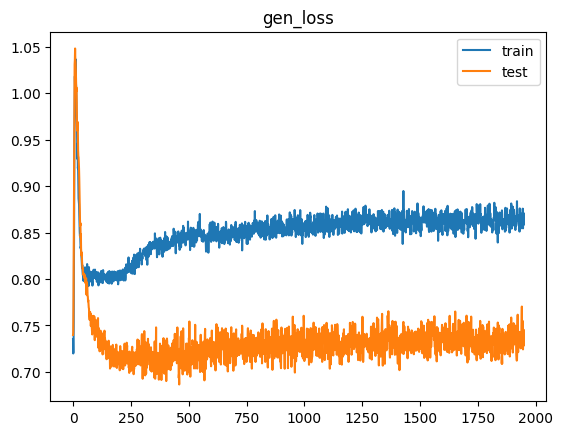

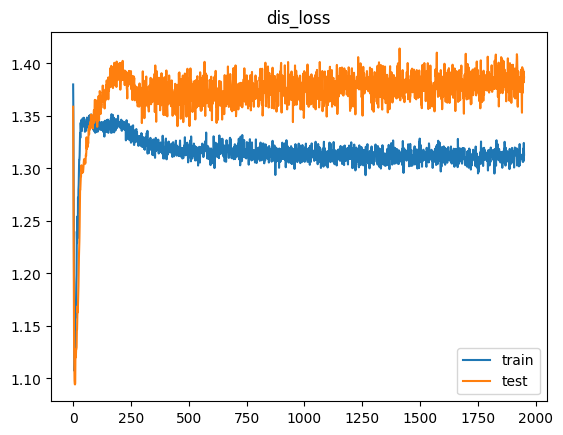

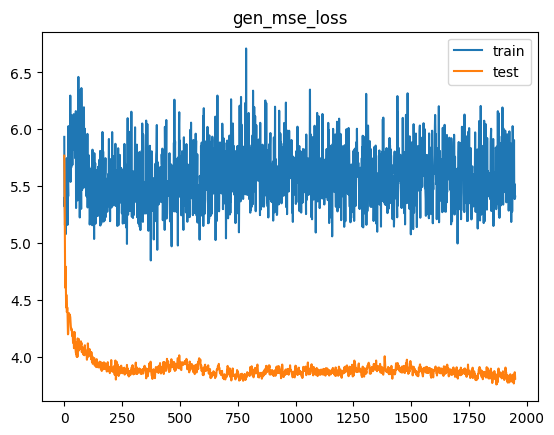

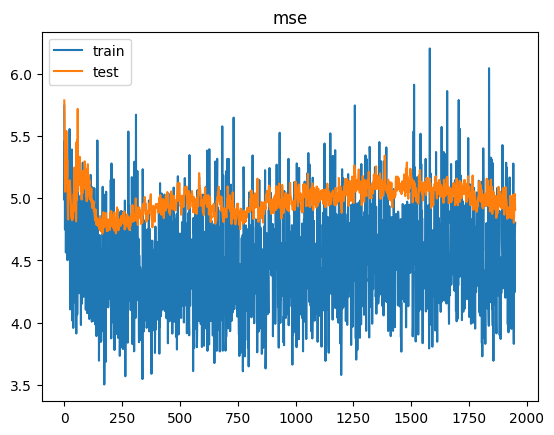

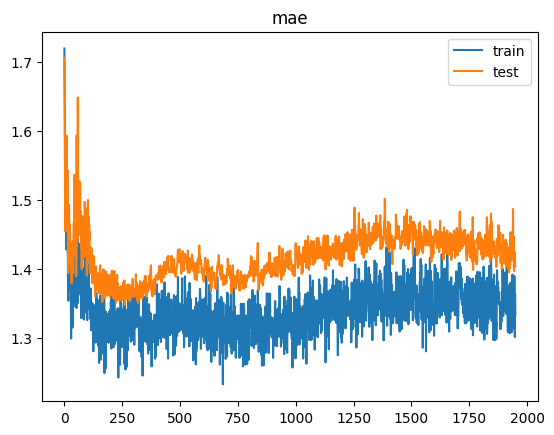

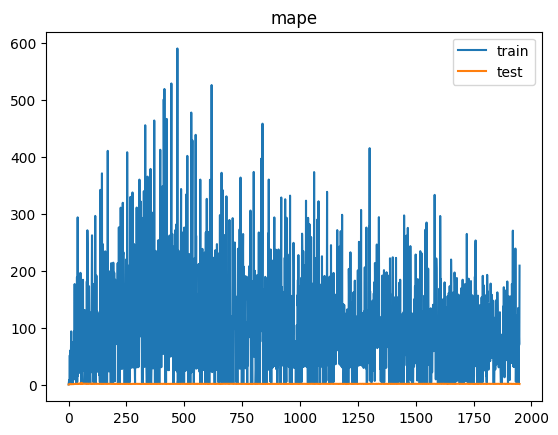

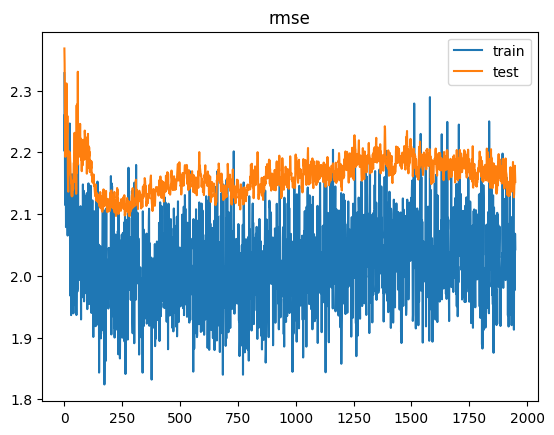

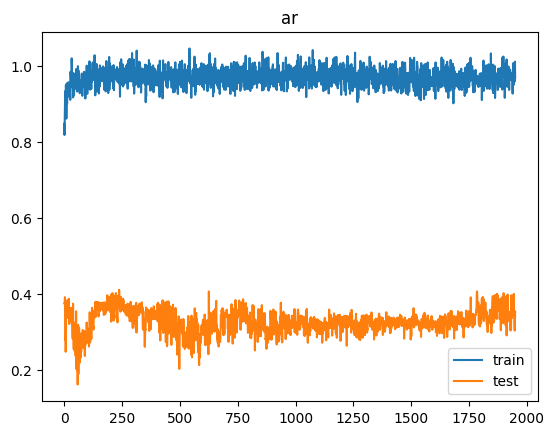

2/2 [==============================] - 1s 10ms/step


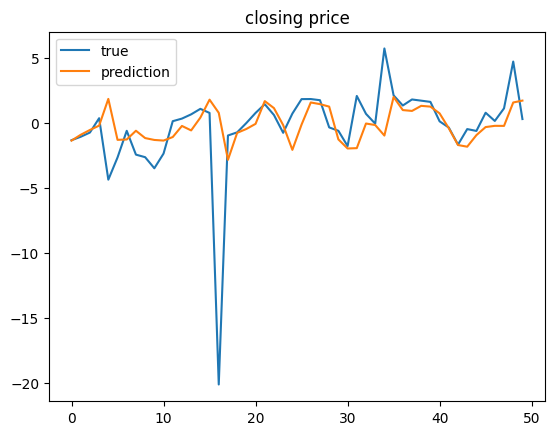

[MSE Baseline] train: 4.588005196092062  test: 4.711719681333692
Delta time with epochs = 1950: 1:08:44.684630


In [20]:
for epochs in [200, 450, 700, 950, 1200, 1450, 1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("dcbilstm_ffnn_epochs_{0}.h5".format(epochs))